In [1]:
import os
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
#import cftime
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import contextily as cx
import re

from pathlib import Path
import pathlib

In [2]:
country = 'TJK'

In [3]:
damage_data_path = Path(pathlib.Path.home().parts[0]) / 'Projects' / 'gmhcira' / 'data' / 'damage' / 'TJK'
eq_damage_data_path = damage_data_path / 'landslide_eq'
his_rainfall_damage_data_path = damage_data_path / 'landslide_rf_historical'
fut126_rainfall_damage_data_path = damage_data_path / 'landslide_rf_ssp126'
fut585_rainfall_damage_data_path = damage_data_path / 'landslide_rf_ssp585'

admin_path = Path('C:\\Users\snn490\OneDrive - Vrije Universiteit Amsterdam\ADB\Data\exposure')
figures_path = Path('C:\\Users\snn490\OneDrive - Vrije Universiteit Amsterdam\ADB\Figures\Landslides')

In [4]:
subnational = gpd.read_file(admin_path / 'gadm41_TJK.gpkg',layer=3)
subnational = subnational.to_crs(3857)

In [5]:
#def calculate_risk(road_segment, damages_dict):
#    damages_lst = [damages_dict[rp][damages_dict[rp]['osm_id'] == road_segment]['Partial destruction (0.5)'].iloc[0] for rp in [*damages_dict]]
#    asset_dam_df = pd.DataFrame([1/rp for rp in [*damages_dict]]+[1,1e-10],damages_lst+[0, max(damages_lst)]).reset_index()
#    asset_dam_df.columns = ['damage','prob']
#    asset_dam_df = asset_dam_df.sort_values('prob',ascending=True).reset_index(drop=True)
#    return np.trapz(asset_dam_df.damage.values,asset_dam_df.prob.values) #np.trapz(y,x)

def calculate_risk_vectorized(row):
    damages_lst = row.values
    rps = row.index
    if isinstance((row.index)[0], str): rps = [int(s) for con_rp in rps for s in re.findall(r'\d+', con_rp)]
    prob_values = np.array([1/rp for rp in rps] + [1/10, 1e-10]) #design standard of rp 10
    damage_values = np.append(damages_lst, [0, max(damages_lst)])
    sorted_indices = np.argsort(prob_values)
    prob_values = prob_values[sorted_indices]
    damage_values = damage_values[sorted_indices]
    return np.trapz(damage_values, prob_values)

def get_province(road_segment,subnational):
    try:
        return subnational.loc[road_segment.geometry.intersects(subnational.geometry)].GID_3.values[0]
    except:
        return None

def handle_zero_values(ead_df, haz_trig_rp_lst):
    """
    Replaces zero values in higher return periods with the value of the previous lower return period,
    if the lower return period has a non-zero value.

    Parameters:
    ead_df (pd.DataFrame): DataFrame containing the 'ead' columns.
    haz_trig_rp_lst (list): List of return periods corresponding to the 'ead' columns.

    Returns:
    pd.DataFrame: Updated DataFrame with zero values replaced.
    """
    # Extract the relevant columns and convert to numpy array for vectorized operations
    values = ead_df[['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst]].values

    # Iterate over the columns, starting from the second column
    for i in range(1, values.shape[1]):
        # Replace zeros with the previous column's value
        values[:, i] = np.where(values[:, i] == 0, values[:, i-1], values[:, i])

    # Convert the numpy array back to a DataFrame and update the original DataFrame
    ead_df[['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst]] = values

    # Extract the relevant columns and convert to numpy array for vectorized operations
    values = ead_df[['ead_{}_overlay'.format(rp_trig) for rp_trig in haz_trig_rp_lst]].fillna(0).values

    # Iterate over the columns, starting from the second column
    for i in range(1, values.shape[1]):
        # Replace zeros with the previous column's value
        values[:, i] = np.where(values[:, i] == 0, values[:, i-1], values[:, i])

    # Convert the numpy array back to a DataFrame and update the original DataFrame
    ead_df[['ead_{}_overlay'.format(rp_trig) for rp_trig in haz_trig_rp_lst]] = values

    # Extract the relevant columns and convert to numpy array for vectorized operations
    values = ead_df[['ead_{}_number_landslides'.format(rp_trig) for rp_trig in haz_trig_rp_lst]].fillna(0).values

    # Iterate over the columns, starting from the second column
    for i in range(1, values.shape[1]):
        # Replace zeros with the previous column's value
        values[:, i] = np.where(values[:, i] == 0, values[:, i-1], values[:, i])

    # Convert the numpy array back to a DataFrame and update the original DataFrame
    ead_df[['ead_{}_number_landslides'.format(rp_trig) for rp_trig in haz_trig_rp_lst]] = values 
    
    return ead_df

# Earthquake-triggered 

In [6]:
# read parquets per return period
haz_trig_rp_lst = [475]
landslide_rp_lst = [2.5, 10.0, 20.0, 100.0, 200.0, 1000.0]
road_types_lst = ['unclassified', 'primary', 'secondary', 'tertiary', 'residential', 
                                'trunk', 'trunk_link',  'motorway','motorway_link',  'primary_link','secondary_link', 'tertiary_link','road', 'track' ]
#create df with all unique ID numbers, geometry and column ead
ead_df = gpd.GeoDataFrame(columns=['osm_id', 'asset', 'geometry']+['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst] 
                          +['ead_{}_overlay'.format(rp_trig) for rp_trig in haz_trig_rp_lst] +['ead_{}_number_landslides'.format(rp_trig) for rp_trig in haz_trig_rp_lst], geometry='geometry')

for rp_trig in haz_trig_rp_lst:
    damage_data_path_list = eq_damage_data_path.iterdir()
    rp_trig_path_list = [path for path in damage_data_path_list if '_trig{}'.format(rp_trig) in str(path)]

    damages_dict = {key: pd.DataFrame() for key in landslide_rp_lst}
    for data_path in rp_trig_path_list:
        df = gpd.read_parquet(data_path)
        damages_dict[df['return_period_landslide'].unique()[0]] = pd.concat([damages_dict[df['return_period_landslide'].unique()[0]], df], ignore_index=True)  #create dictionary with the return period 

    #modify dictionaries 
    non_empty_rps = [key for key, df in damages_dict.items() if not df.empty]
    if non_empty_rps:
        lowest_non_empty_rp = min(non_empty_rps)
        damages_dict = {key: df for key, df in damages_dict.items() if key >= lowest_non_empty_rp} # Step 1: Remove all keys above this return period
        highest_non_empty_rp = max(non_empty_rps)
        damages_dict = {key: df for key, df in damages_dict.items() if key <= highest_non_empty_rp} # Step 2: Remove all keys below this return period
        for rp in damages_dict.keys():
            #print('This is the total damage for landslide return period {} given rainfall event of {}: {:,.2f}; exposed roads: {:.2f} km'.format(rp, rp_trig, damages_dict[rp]['Partial destruction (0.5)'].sum(), damages_dict[rp]['Overlay'].sum()/1000))
            print('This is the total damage for landslide return period {} given rainfall event of {}: {:,.2f}'.format(rp, rp_trig, damages_dict[rp]['Partial destruction (0.5)'].sum()))   
        
        # Calculate EAD per OSM road segment for rainfall event
        combined_df = pd.concat([damages_dict[rp] for rp in damages_dict.keys()]) #merge dataframes into one
        combined_df['Partial destruction (0.5)'] = combined_df['Partial destruction (0.5)'].fillna(0)
        temp_df = combined_df.drop_duplicates(subset=['osm_id']) # remove duplicates
        ead_df = pd.merge(ead_df, temp_df[['osm_id', 'asset', 'geometry']], on=['osm_id', 'asset', 'geometry'], how='outer')
        
        pivoted_damages = combined_df.pivot_table(index='osm_id', columns='return_period_landslide', values='Partial destruction (0.5)', fill_value=0)
        
        print("Unique osm_id in original data:", combined_df['osm_id'].nunique()) # Print unique osm_id from the original DataFrame
        print("Unique osm_id in pivoted data:", pivoted_damages.index.nunique()) # Print unique osm_id from the pivoted DataFrame
        missing_ids = set(combined_df['osm_id']) - set(pivoted_damages.index) # Check if some osm_id values are missing from pivoted_damages
        print("Missing osm_id values:", missing_ids)
        
        ead_df['ead_{}'.format(rp_trig)] = ead_df.apply(lambda row: calculate_risk_vectorized(pivoted_damages.loc[row['osm_id']]) if row['osm_id'] in pivoted_damages.index else 0, axis=1)

        #fill in overlay columns
        overlay_dict = damages_dict[highest_non_empty_rp].set_index('osm_id')['Overlay'].to_dict()
        ead_df['ead_{}_overlay'.format(rp_trig)] = ead_df['osm_id'].map(overlay_dict)

        #fill in number of landslides columns
        number_landslide_dict = damages_dict[highest_non_empty_rp].set_index('osm_id')['number of landslides'].to_dict()
        ead_df['ead_{}_number_landslides'.format(rp_trig)] = ead_df['osm_id'].map(number_landslide_dict)

ead_df = handle_zero_values(ead_df, haz_trig_rp_lst) # Handle 0 values for higher return periods with damages for the lower return periods

This is the total damage for landslide return period 2.5 given rainfall event of 475: 0.00
This is the total damage for landslide return period 10.0 given rainfall event of 475: 0.00
This is the total damage for landslide return period 20.0 given rainfall event of 475: 26,540,366.49
This is the total damage for landslide return period 100.0 given rainfall event of 475: 316,340,501.83
This is the total damage for landslide return period 200.0 given rainfall event of 475: 1,041,585,995.83
This is the total damage for landslide return period 1000.0 given rainfall event of 475: 2,143,986,142.06
Unique osm_id in original data: 82984
Unique osm_id in pivoted data: 82984
Missing osm_id values: set()


In [7]:
ead_df

osm_id        asset  \
0      1000015176  residential   
1      1000015177  residential   
2      1000015178  residential   
3      1000027175        track   
4      1000027177        track   
...           ...          ...   
82979   999921517  residential   
82980   999921518  residential   
82981    99993370  residential   
82982    99993371  residential   
82983    99995066  residential   

                                                geometry    ead_475  \
0      LINESTRING (69.91323 37.89481, 69.91334 37.894...   0.000000   
1      LINESTRING (69.91340 37.89503, 69.91352 37.895...   0.000000   
2      LINESTRING (69.91358 37.89523, 69.91329 37.89549)   0.000000   
3      LINESTRING (69.87285 38.17199, 69.87296 38.171...   0.000000   
4      LINESTRING (69.87082 38.17312, 69.87108 38.173...  90.036423   
...                                                  ...        ...   
82979  LINESTRING (69.84537 38.28370, 69.84555 38.284...   0.000000   
82980  LINESTRING (69.84557 38.28529, 69.84549 38.285...   0.000000   
82981  LINESTRING (68.74956 38.53461, 68.75042 38.53648)   0.000000   
82982  LINESTRING (68.75042 38.53648, 68.75064 38.537...   0.000000   
82983  LINESTRING (68.74148 38.57223, 68.74165 38.572...   0.000000   

       ead_475_overlay  ead_475_number_landslides  
0             0.000000                        0.0  
1             0.000000                        0.0  
2             0.000000                        0.0  
3             0.000000                        0.0  
4           200.080948                        3.0  
...                ...                        ...  
82979         0.000000                        0.0  
82980         0.000000                        0.0  
82981         0.000000                        0.0  
82982         0.000000                        0.0  
82983         0.000000                        0.0  

[82984 rows x 6 columns]

In [12]:
# Calculate EAD for earthquake-triggered landslides
ead_df[['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst]] = ead_df[['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst]].fillna(0)
temp_df = (ead_df.filter(['osm_id']+['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst], axis=1)).set_index('osm_id') #create df with only ead columns
ead_df['ead'] = ead_df.apply(lambda row: calculate_risk_vectorized(temp_df.loc[row['osm_id']]), axis=1)
ead_df = ead_df.to_crs(3857)

for rp_trig in haz_trig_rp_lst:
    print('This is the EAD given earthquake event of {}: {:,}'.format(rp_trig, ead_df['ead_{}'.format(rp_trig)].sum()))
print('This is the national EAD for earthquake-triggered landslides: {}'.format(sum(ead_df['ead'])))
print('This is the max EAD for earthquake-triggered landslides for a road segment: {}'.format(max(ead_df['ead'])))

This is the EAD given earthquake event of 475: 19,431,072.976228174
This is the national EAD for earthquake-triggered landslides: 992007.4078959101
This is the max EAD for earthquake-triggered landslides for a road segment: 29688.293798117127


In [13]:
ead_df

osm_id        asset  \
0      1000015176  residential   
1      1000015177  residential   
2      1000015178  residential   
3      1000027175        track   
4      1000027177        track   
...           ...          ...   
82979   999921517  residential   
82980   999921518  residential   
82981    99993370  residential   
82982    99993371  residential   
82983    99995066  residential   

                                                geometry    ead_475  \
0      LINESTRING (7782705.330 4564576.153, 7782717.3...   0.000000   
1      LINESTRING (7782724.555 4564607.850, 7782737.9...   0.000000   
2      LINESTRING (7782744.292 4564636.373, 7782712.1...   0.000000   
3      LINESTRING (7778210.260 4603750.917, 7778222.7...   0.000000   
4      LINESTRING (7777983.581 4603910.302, 7778013.4...  90.036423   
...                                                  ...        ...   
82979  LINESTRING (7775151.045 4619581.078, 7775171.3...   0.000000   
82980  LINESTRING (7775173.064 4619806.300, 7775164.4...   0.000000   
82981  LINESTRING (7653166.156 4655226.289, 7653261.7...   0.000000   
82982  LINESTRING (7653261.702 4655492.313, 7653285.8...   0.000000   
82983  LINESTRING (7652266.561 4660580.797, 7652285.2...   0.000000   

       ead_475_overlay  ead_475_number_landslides GID_3       ead  
0             0.000000                        0.0  None  0.000000  
1             0.000000                        0.0  None  0.000000  
2             0.000000                        0.0  None  0.000000  
3             0.000000                        0.0  None  0.000000  
4           200.080948                        3.0  None  4.596596  
...                ...                        ...   ...       ...  
82979         0.000000                        0.0  None  0.000000  
82980         0.000000                        0.0  None  0.000000  
82981         0.000000                        0.0  None  0.000000  
82982         0.000000                        0.0  None  0.000000  
82983         0.000000                        0.0  None  0.000000  

[82984 rows x 8 columns]

In [14]:
subnational_df = gpd.read_file(admin_path / 'gadm41_TJK.gpkg',layer=3)
subnational_df = subnational_df.to_crs(3857)
ead_df['GID_3'] = ead_df.apply(lambda road_segment: get_province(road_segment, subnational), axis=1)
subnational_df = subnational_df.merge(ead_df[['GID_3','ead']].groupby('GID_3').sum(),left_on='GID_3',right_index=True)
subnational_df[['NAME_2','ead']].groupby('NAME_2').sum().sort_values(by='ead',ascending=False)

ead
NAME_2                              
Ayni                   164227.066910
Darvoz                 136514.108488
Jirgatol               115437.447601
Rasht                   88529.205851
Kuhistoni Mastchoh      79510.254509
Tavildara               62202.038662
Nurobod                 50627.058785
Varzob                  39572.530298
Rushon                  30881.820720
Vanj                    22584.683660
Murghob                 18346.036809
Pandjakent              17841.033623
Shurobod                17588.628605
Ghonchi                 11024.260629
Norak                   10838.818584
Roghun                  10511.065328
Khovaling                9244.403865
Tojikobod                8892.950955
Danghara                 7546.154722
Vahdat                   6892.247101
Shughnon                 6875.017252
Ishkoshim                6466.475324
Muminobod                5948.704936
Baljuvon                 5812.957577
Roshtqala                5741.474173
Mir Said Ali Hamadoni    4965.867039
Rudaki                   4765.793493
Yovon                    4080.260610
Temurmalik               4042.402907
Hissor                   2632.382761
Shahrinav                2492.570467
Shahriston               2262.959863
Isfara                   2170.951633
Jomi                     2064.940445
Panj                     1636.604694
Fayzobod                 1287.207147
Farkhor                  1229.404868
Asht                     1117.187927
Khuroson                  756.487152
Ghafurov                  613.653126
Kulob                     582.430602
Matchin                   553.987051
Istaravshan               547.830834
Shahrituz                 435.322411
Qabodiyon                 349.220939
Vose                      334.290270
Jilikul                   316.909148
Nosir Khusrav             212.262193
Kolkhozobod               156.734858
Spitamen                  141.011556
Tursunzoda                129.967228
Jabor Rasulov              32.337418
Qumsangir                  25.127389
Sarband                    22.340163
Vakhsh                      0.000000
Konibodom                   0.000000
Bokhtar                     0.000000
Zafarobod                   0.000000

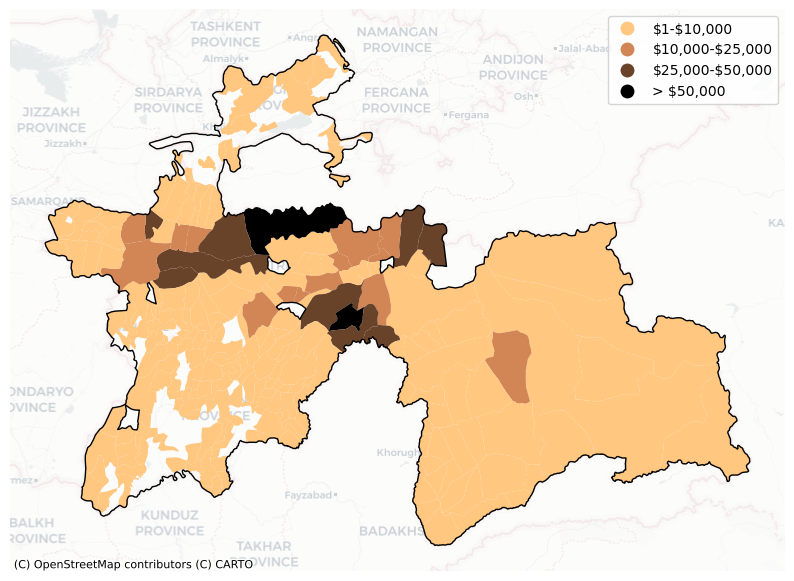

In [22]:
subnational_df['binned'] =  pd.cut(subnational_df.ead,[0,1e4,2.5e4,5e4,subnational_df.ead.max()],labels=['\\$1-$10,000','\\$10,000-$25,000','\\$25,000-$50,000','> $50,000'])

fig, ax = plt.subplots(1,1,figsize=(10, 10))

subnational_df.plot(column = 'binned',cmap='copper_r',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
subnational_df.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')
ax.set_axis_off()

plt.savefig(figures_path /'landslide_eq_EAD_municipal.png', bbox_inches='tight', dpi=300)

In [24]:
subnational_df.ead.max()

63595.80041564454

In [29]:
ead_df['damage/km'] = ead_df.ead/(ead_df.ead_475_overlay/1000)
ead_df['damage/km'].max()

2104.2463533485575

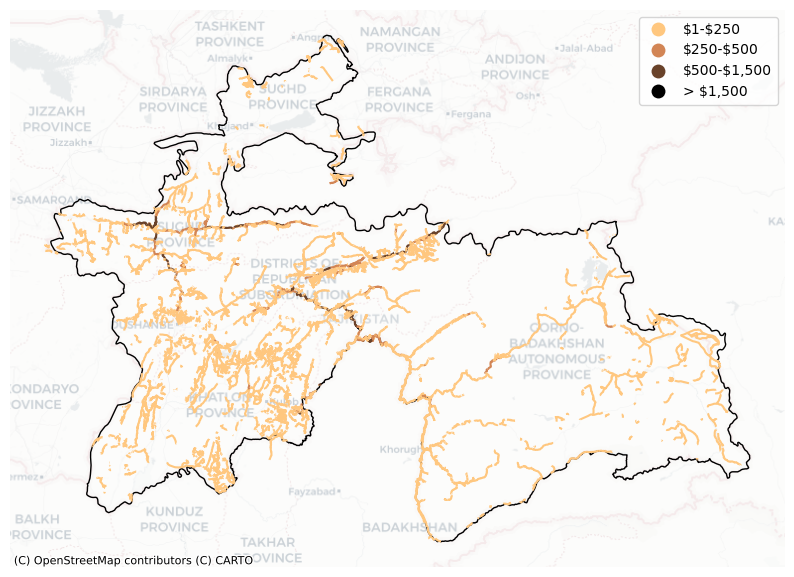

In [32]:
# figure EAD damages per km per road segment
ead_df['damage/km_binned'] = pd.cut(ead_df['damage/km'],[0,2.5e2,5e2,1.5e3,ead_df['damage/km'].max()],labels=['\\$1-$250','\\$250-$500','\\$500-$1,500','> $1,500'])
ead_df = gpd.GeoDataFrame(ead_df, geometry='geometry') # Set the GeoDataFrame's geometry column
ead_df = ead_df.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

ead_df.plot(column ='damage/km_binned',cmap='copper_r',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

plt.savefig(figures_path /'landslide_eq_EAD_km.png', bbox_inches='tight', dpi=300)

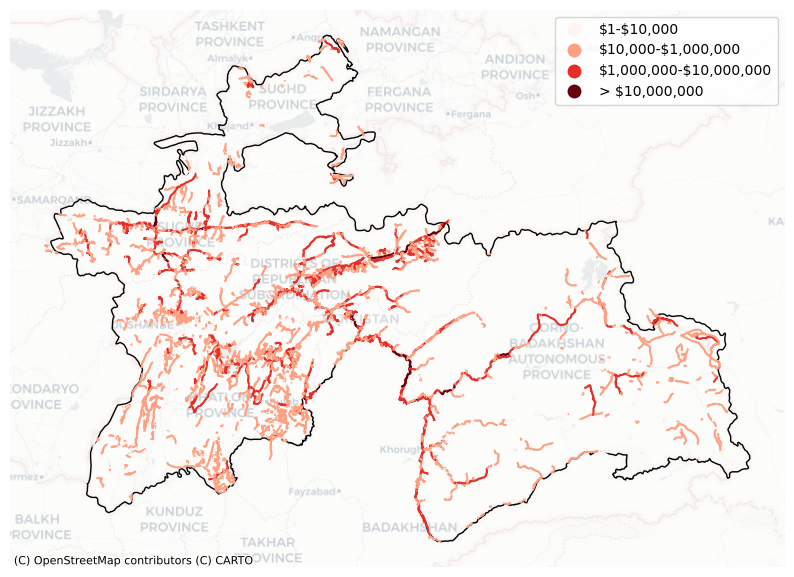

In [36]:
# figure 1/1000 landslide events given a 475 year eq-RP: damages per OSM road segment
damages_dict[1000]['binned'] = pd.cut(damages_dict[1000]['Partial destruction (0.5)'],[0,1e4,1e6,1e7,damages_dict[1000]['Partial destruction (0.5)'].max()],labels=['\\$1-$10,000','\\$10,000-$1,000,000','\\$1,000,000-$10,000,000','> $10,000,000'])
damage_df = damages_dict[1000].to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

damage_df.plot(column = 'binned',cmap='Reds',legend=True,ax=ax)
#damage_df.plot(column ='Partial destruction (0.5)',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

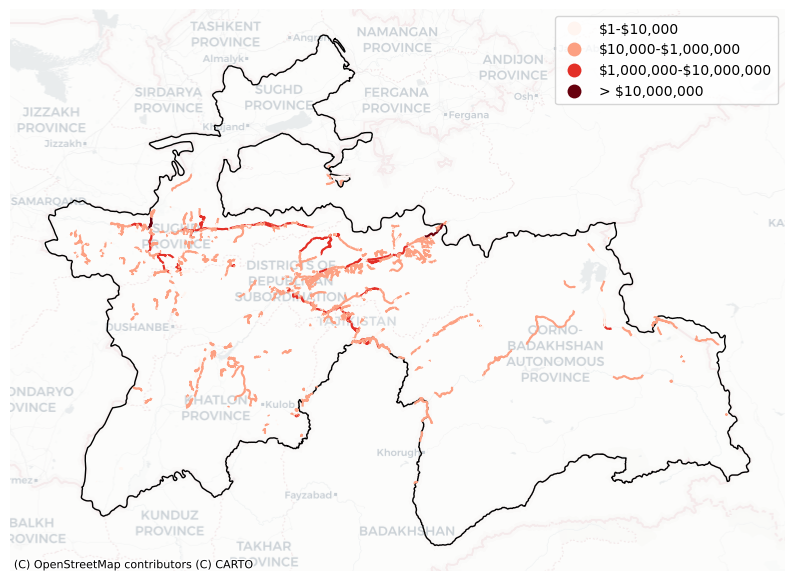

In [37]:
# figure 1/100 landslide events given a 475 year eq-RP: damages per OSM road segment
damages_dict[100]['binned'] = pd.cut(damages_dict[100]['Partial destruction (0.5)'],[0,1e4,1e6,1e7,damages_dict[1000]['Partial destruction (0.5)'].max()],labels=['\\$1-$10,000','\\$10,000-$1,000,000','\\$1,000,000-$10,000,000','> $10,000,000'])
damage_df = damages_dict[100].to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

damage_df.plot(column = 'binned',cmap='Reds',legend=True,ax=ax)
#damage_df.plot(column ='Partial destruction (0.5)',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

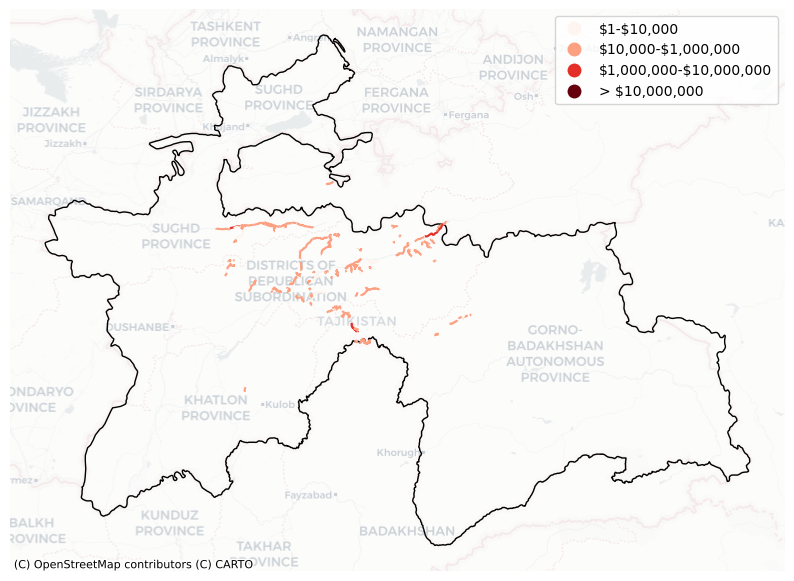

In [38]:
# figure 1/20 landslide events given a 475 year eq-RP: damages per OSM road segment
damages_dict[20]['binned'] = pd.cut(damages_dict[20]['Partial destruction (0.5)'],[0,1e4,1e6,1e7,damages_dict[1000]['Partial destruction (0.5)'].max()],labels=['\\$1-$10,000','\\$10,000-$1,000,000','\\$1,000,000-$10,000,000','> $10,000,000'])
damage_df = damages_dict[20].to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

damage_df.plot(column = 'binned',cmap='Reds',legend=True,ax=ax)
#damage_df.plot(column ='Partial destruction (0.5)',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

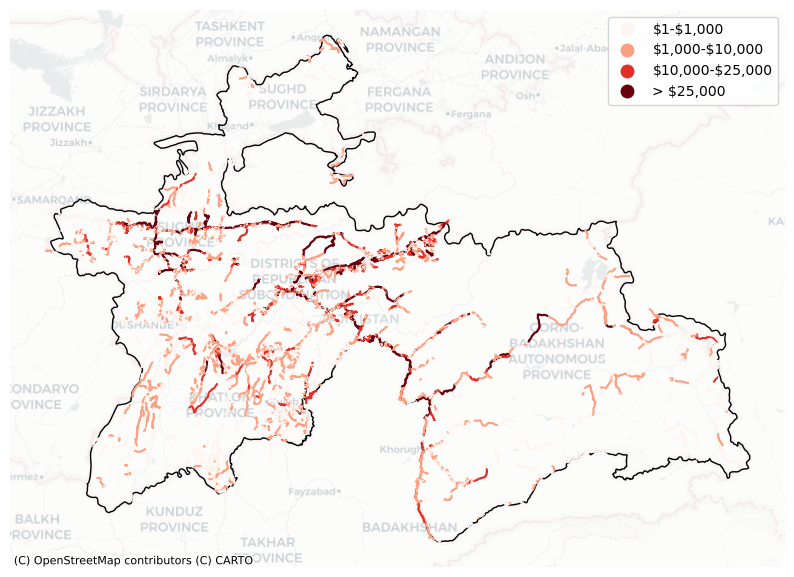

In [39]:
# figure EAD due to earthquake-triggered landslide events given a 475 year eq-RP: damages per OSM road segment
ead_df['ead_475_binned'] = pd.cut(ead_df['ead_475'],[0,1e3,1e4,2.5e4,ead_df['ead_475'].max()],labels=['\\$1-$1,000','\\$1,000-$10,000','\\$10,000-$25,000','> $25,000'])
ead_df = gpd.GeoDataFrame(ead_df, geometry='geometry') # Set the GeoDataFrame's geometry column
ead_df = ead_df.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

ead_df.plot(column ='ead_475_binned',cmap='Reds',legend=True,ax=ax)
#damage_df.plot(column ='Partial destruction (0.5)',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

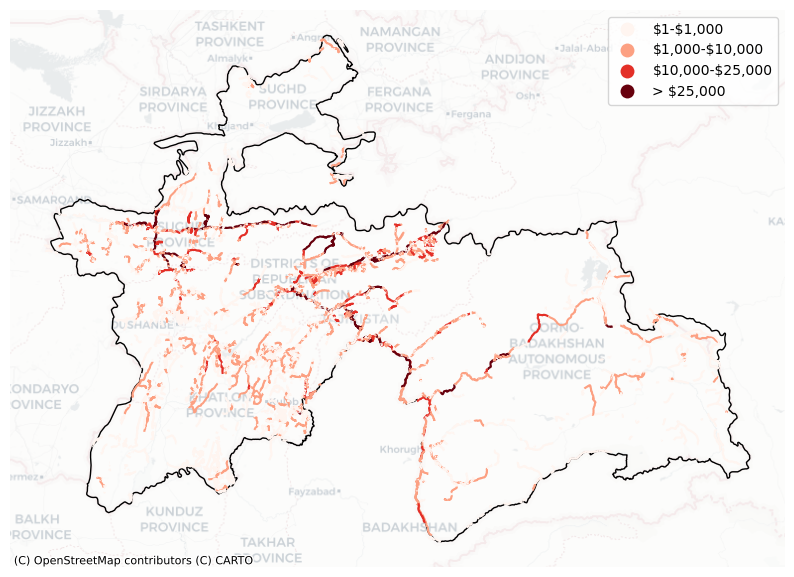

In [40]:
# figure EAD due to earthquake-triggered landslides: damages per OSM road segment
ead_df['ead_binned'] = pd.cut(ead_df['ead'],[0,1e3,1e4,2.5e4,ead_df['ead'].max()],labels=['\\$1-$1,000','\\$1,000-$10,000','\\$10,000-$25,000','> $25,000'])
ead_df = gpd.GeoDataFrame(ead_df, geometry='geometry') # Set the GeoDataFrame's geometry column
ead_df = ead_df.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

ead_df.plot(column ='ead_binned',cmap='Reds',legend=True,ax=ax)
#damage_df.plot(column ='Partial destruction (0.5)',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

plt.savefig(figures_path /'landslide_eq_EAD.png', bbox_inches='tight', dpi=300)

In [44]:
# project road of interest
dangara_gulliston_ids = dangara_gulliston_ids = ['629623298', '588578885', '667337582', '32623282', '32623136']
project_df = ead_df[ead_df['osm_id'].isin(dangara_gulliston_ids)]

project_df

osm_id      asset  \
33630   32623136    primary   
33631   32623282    primary   
56678  588578885    primary   
58752  629623298  secondary   
61068  667337582    primary   

                                                geometry     ead_475  \
33630  LINESTRING (7736373.045 4543194.954, 7736307.6...    0.000000   
33631  LINESTRING (7722016.760 4553162.418, 7721756.9...  721.828979   
56678  LINESTRING (7717996.190 4586923.107, 7718996.8...    0.000000   
58752  LINESTRING (7718612.287 4592854.748, 7718613.9...    0.000000   
61068  LINESTRING (7720909.666 4582235.532, 7720692.5...    0.000000   

       ead_475_overlay  ead_475_number_landslides        ead        GID_3  \
33630         0.000000                        0.0    0.00000  TJK.3.3.7_1   
33631       240.609668                        3.0  361.67431  TJK.3.3.7_1   
56678         0.000000                        0.0    0.00000  TJK.3.3.3_1   
58752         0.000000                        0.0    0.00000  TJK.3.3.3_1   
61068         0.000000                        0.0    0.00000  TJK.3.3.7_1   

      ead_475_binned  ead_binned  
33630            NaN         NaN  
33631     \$1-$1,000  \$1-$1,000  
56678            NaN         NaN  
58752            NaN         NaN  
61068            NaN         NaN

In [45]:
print(shapely.length(ead_df[ead_df['osm_id'].isin(dangara_gulliston_ids)]['geometry'])/1000) # length of road segments in km
print(sum(shapely.length(ead_df[ead_df['osm_id'].isin(dangara_gulliston_ids)]['geometry'])/1000)) # total length of road segments in km

33630    22.976544
33631    20.829034
56678     6.368039
58752     6.674631
61068    10.498568
Name: geometry, dtype: float64
67.34681578690605


In [47]:
damage = sum(project_df['ead'])
affected_road = sum(project_df['ead_475_overlay'])/1000
number_of_landslides = sum(project_df['ead_475_number_landslides'])
road_segments_length = 20.829034

print('The expected annual damage for Dangara-Gulliston road project, based on total length of project road: {:.2f} dollar per km'.format(damage/67.34681578690605))
print('The expected annual damage for Dangara-Gulliston road project, based on length of affected OSM road segment: {:.2f} dollar per km'.format(damage/road_segments_length)) 
print('The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: {:.2f} dollar per km'.format(damage/affected_road)) 
print('The expected annual damage for Dangara-Gulliston road project per landslide event: {:.2f} dollar'.format(damage/number_of_landslides)) #shouldn't we divide by the average landslides per year?

The expected annual damage for Dangara-Gulliston road project, based on total length of project road: 5.37 dollar per km
The expected annual damage for Dangara-Gulliston road project, based on length of affected OSM road segment: 17.36 dollar per km
The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: 1503.16 dollar per km
The expected annual damage for Dangara-Gulliston road project per landslide event: 120.56 dollar


In [48]:
sum(project_df['ead'])

361.6743095192529

In [49]:
sum(project_df['ead_475_overlay'])/1000

0.2406096677625239

In [9]:
# exposed roads
print("This is the road length exposed at national level: {:.2f}".format(ead_df.ead_475_overlay.sum()/1000))
print("This is the EAD at national level: {:.2f}".format(ead_df.ead.sum()))

affected_road = ead_df.ead_475_overlay.sum()/1000
damage = ead_df.ead.sum()
print('The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: {:.2f} dollar per km'.format(damage/affected_road))

This is the road length exposed at national level: 7472.20
This is the EAD at national level: 9735990.25
The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: 1302.96 dollar per km


# Rainfall-triggered 

## Historical conditions

In [34]:
#read parquets per return period
haz_trig_rp_lst = [5, 25, 200, 1000]
landslide_rp_lst = [5.0, 7.0, 10.0, 20.0, 33.0, 50.0, 100.0]
road_types_lst = ['unclassified', 'primary', 'secondary', 'tertiary', 'residential', 
                                'trunk', 'trunk_link',  'motorway','motorway_link',  'primary_link','secondary_link', 'tertiary_link','road', 'track' ]

#create df with all unique ID numbers, geometry and column ead
ead_df = gpd.GeoDataFrame(columns=['osm_id', 'asset', 'geometry']+['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst] 
                          +['ead_{}_overlay'.format(rp_trig) for rp_trig in haz_trig_rp_lst] +['ead_{}_number_landslides'.format(rp_trig) for rp_trig in haz_trig_rp_lst], geometry='geometry')

for rp_trig in haz_trig_rp_lst:
    damage_data_path_list = his_rainfall_damage_data_path.iterdir()
    rp_trig_path_list = [path for path in damage_data_path_list if '_trig{}'.format(rp_trig) in str(path)]

    damages_dict = {key: pd.DataFrame() for key in landslide_rp_lst}
    for data_path in rp_trig_path_list:
        df = gpd.read_parquet(data_path)
        damages_dict[df['return_period_landslide'].unique()[0]] = pd.concat([damages_dict[df['return_period_landslide'].unique()[0]], df], ignore_index=True)  #create dictionary with the return period 

    #modify dictionaries 
    non_empty_rps = [key for key, df in damages_dict.items() if not df.empty]
    if non_empty_rps:
        lowest_non_empty_rp = min(non_empty_rps)
        damages_dict = {key: df for key, df in damages_dict.items() if key >= lowest_non_empty_rp} # Step 1: Remove all keys above this return period
        highest_non_empty_rp = max(non_empty_rps)
        damages_dict = {key: df for key, df in damages_dict.items() if key <= highest_non_empty_rp} # Step 2: Remove all keys below this return period
        for rp in damages_dict.keys():
            #print('This is the total damage for landslide return period {} given rainfall event of {}: {:,.2f}; exposed roads: {:.2f} km'.format(rp, rp_trig, damages_dict[rp]['Partial destruction (0.5)'].sum(), damages_dict[rp]['Overlay'].sum()/1000))
            print('This is the total damage for landslide return period {} given rainfall event of {}: {:,.2f}'.format(rp, rp_trig, damages_dict[rp]['Partial destruction (0.5)'].sum()))   
        
        # Calculate EAD per OSM road segment for rainfall event
        combined_df = pd.concat([damages_dict[rp] for rp in damages_dict.keys()]) #merge dataframes into one
        combined_df['Partial destruction (0.5)'] = combined_df['Partial destruction (0.5)'].fillna(0)
        temp_df = combined_df.drop_duplicates(subset=['osm_id']) # remove duplicates
        ead_df = pd.merge(ead_df, temp_df[['osm_id', 'asset', 'geometry']], on=['osm_id', 'asset', 'geometry'], how='outer')
        
        pivoted_damages = combined_df.pivot_table(index='osm_id', columns='return_period_landslide', values='Partial destruction (0.5)', fill_value=0)
        
        print("Unique osm_id in original data:", combined_df['osm_id'].nunique()) # Print unique osm_id from the original DataFrame
        print("Unique osm_id in pivoted data:", pivoted_damages.index.nunique()) # Print unique osm_id from the pivoted DataFrame
        missing_ids = set(combined_df['osm_id']) - set(pivoted_damages.index) # Check if some osm_id values are missing from pivoted_damages
        print("Missing osm_id values:", missing_ids)
        
        ead_df['ead_{}'.format(rp_trig)] = ead_df.apply(lambda row: calculate_risk_vectorized(pivoted_damages.loc[row['osm_id']]) if row['osm_id'] in pivoted_damages.index else 0, axis=1)

        #fill in overlay columns
        overlay_dict = damages_dict[highest_non_empty_rp].set_index('osm_id')['Overlay'].to_dict()
        ead_df['ead_{}_overlay'.format(rp_trig)] = ead_df['osm_id'].map(overlay_dict)

        #fill in number of landslides columns
        number_landslide_dict = damages_dict[highest_non_empty_rp].set_index('osm_id')['number of landslides'].to_dict()
        ead_df['ead_{}_number_landslides'.format(rp_trig)] = ead_df['osm_id'].map(number_landslide_dict)

ead_df = handle_zero_values(ead_df, haz_trig_rp_lst) # Handle 0 values for higher return periods with damages for the lower return periods

This is the total damage for landslide return period 20.0 given rainfall event of 5: 170,202.56
This is the total damage for landslide return period 33.0 given rainfall event of 5: 800,044.10
This is the total damage for landslide return period 50.0 given rainfall event of 5: 6,835,793.36
This is the total damage for landslide return period 100.0 given rainfall event of 5: 50,462,759.25
Unique osm_id in original data: 82856
Unique osm_id in pivoted data: 82856
Missing osm_id values: set()
This is the total damage for landslide return period 10.0 given rainfall event of 25: 16,954,400.66
This is the total damage for landslide return period 20.0 given rainfall event of 25: 106,757,169.23
This is the total damage for landslide return period 33.0 given rainfall event of 25: 754,016,617.78
This is the total damage for landslide return period 50.0 given rainfall event of 25: 3,188,302,803.97
Unique osm_id in original data: 83324
Unique osm_id in pivoted data: 83324
Missing osm_id values: set

In [35]:
ead_df

osm_id        asset  \
0      1000015176  residential   
1      1000015177  residential   
2      1000015178  residential   
3      1000027175        track   
4      1000027177        track   
...           ...          ...   
83319   999921517  residential   
83320   999921518  residential   
83321    99993370  residential   
83322    99993371  residential   
83323    99995066  residential   

                                                geometry  ead_5       ead_25  \
0      LINESTRING (69.91323 37.89481, 69.91334 37.894...    0.0     0.000000   
1      LINESTRING (69.91340 37.89503, 69.91352 37.895...    0.0     0.000000   
2      LINESTRING (69.91358 37.89523, 69.91329 37.89549)    0.0     0.000000   
3      LINESTRING (69.87285 38.17199, 69.87296 38.171...    0.0  1357.902054   
4      LINESTRING (69.87082 38.17312, 69.87108 38.173...    0.0  1631.947524   
...                                                  ...    ...          ...   
83319  LINESTRING (69.84537 38.28370, 69.84555 38.284...    0.0  2840.517716   
83320  LINESTRING (69.84557 38.28529, 69.84549 38.285...    0.0   946.253380   
83321  LINESTRING (68.74956 38.53461, 68.75042 38.53648)    0.0     0.000000   
83322  LINESTRING (68.75042 38.53648, 68.75064 38.537...    0.0     0.000000   
83323  LINESTRING (68.74148 38.57223, 68.74165 38.572...    0.0     0.000000   

           ead_200     ead_1000  ead_5_overlay  ead_25_overlay  \
0         0.000000     0.000000            0.0        0.000000   
1         0.000000     0.000000            0.0        0.000000   
2         0.000000     0.000000            0.0        0.000000   
3      2167.735211  4049.165775            0.0      359.925847   
4      2932.430869  4274.242533            0.0      313.239021   
...            ...          ...            ...             ...   
83319  4534.561421  4534.561421            0.0      451.744988   
83320  1510.585218  1510.585218            0.0      150.488490   
83321     0.000000     0.000000            0.0        0.000000   
83322     0.000000     0.000000            0.0        0.000000   
83323     0.000000     0.000000            0.0        0.000000   

       ead_200_overlay  ead_1000_overlay  ead_5_number_landslides  \
0             0.000000          0.000000                      0.0   
1             0.000000          0.000000                      0.0   
2             0.000000          0.000000                      0.0   
3           359.925847        359.925847                      0.0   
4           313.239021        313.239021                      0.0   
...                ...               ...                      ...   
83319       451.744988        451.744988                      0.0   
83320       150.488490        150.488490                      0.0   
83321         0.000000          0.000000                      0.0   
83322         0.000000          0.000000                      0.0   
83323         0.000000          0.000000                      0.0   

       ead_25_number_landslides  ead_200_number_landslides  \
0                           0.0                        0.0   
1                           0.0                        0.0   
2                           0.0                        0.0   
3                           5.0                        5.0   
4                           5.0                        5.0   
...                         ...                        ...   
83319                       7.0                        7.0   
83320                       3.0                        3.0   
83321                       0.0                        0.0   
83322                       0.0                        0.0   
83323                       0.0                        0.0   

       ead_1000_number_landslides  
0                             0.0  
1                             0.0  
2                             0.0  
3                             5.0  
4                             5.0  
...                           ...  
83319                 

In [36]:
# Calculate EAD for landslide-triggered landslides
ead_df[['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst]] = ead_df[['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst]].fillna(0)
temp_df = (ead_df.filter(['osm_id']+['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst], axis=1)).set_index('osm_id') #create df with only ead columns
ead_df['ead'] = ead_df.apply(lambda row: calculate_risk_vectorized(temp_df.loc[row['osm_id']]), axis=1)
ead_df = ead_df.to_crs(3857)

for rp_trig in haz_trig_rp_lst:
    print('This is the EAD given rainfall event of {}: {:,}'.format(rp_trig, ead_df['ead_{}'.format(rp_trig)].sum()))
print('This is the national EAD for rainfall-triggered landslides: {}'.format(sum(ead_df['ead'])))
print('This is the max EAD for rainfall-triggered landslides for a road segment: {}'.format(max(ead_df['ead'])))

This is the EAD given rainfall event of 5: 844,267.0062456012
This is the EAD given rainfall event of 25: 95,645,080.84036133
This is the EAD given rainfall event of 200: 177,681,391.2847446
This is the EAD given rainfall event of 1000: 200,502,651.8636295
This is the national EAD for rainfall-triggered landslides: 8651696.717038093
This is the max EAD for rainfall-triggered landslides for a road segment: 75789.15739245614


In [37]:
ead_df 

osm_id        asset  \
0      1000015176  residential   
1      1000015177  residential   
2      1000015178  residential   
3      1000027175        track   
4      1000027177        track   
...           ...          ...   
83319   999921517  residential   
83320   999921518  residential   
83321    99993370  residential   
83322    99993371  residential   
83323    99995066  residential   

                                                geometry  ead_5       ead_25  \
0      LINESTRING (7782705.330 4564576.153, 7782717.3...    0.0     0.000000   
1      LINESTRING (7782724.555 4564607.850, 7782737.9...    0.0     0.000000   
2      LINESTRING (7782744.292 4564636.373, 7782712.1...    0.0     0.000000   
3      LINESTRING (7778210.260 4603750.917, 7778222.7...    0.0  1357.902054   
4      LINESTRING (7777983.581 4603910.302, 7778013.4...    0.0  1631.947524   
...                                                  ...    ...          ...   
83319  LINESTRING (7775151.045 4619581.078, 7775171.3...    0.0  2840.517716   
83320  LINESTRING (7775173.064 4619806.300, 7775164.4...    0.0   946.253380   
83321  LINESTRING (7653166.156 4655226.289, 7653261.7...    0.0     0.000000   
83322  LINESTRING (7653261.702 4655492.313, 7653285.8...    0.0     0.000000   
83323  LINESTRING (7652266.561 4660580.797, 7652285.2...    0.0     0.000000   

           ead_200     ead_1000  ead_5_overlay  ead_25_overlay  \
0         0.000000     0.000000            0.0        0.000000   
1         0.000000     0.000000            0.0        0.000000   
2         0.000000     0.000000            0.0        0.000000   
3      2167.735211  4049.165775            0.0      359.925847   
4      2932.430869  4274.242533            0.0      313.239021   
...            ...          ...            ...             ...   
83319  4534.561421  4534.561421            0.0      451.744988   
83320  1510.585218  1510.585218            0.0      150.488490   
83321     0.000000     0.000000            0.0        0.000000   
83322     0.000000     0.000000            0.0        0.000000   
83323     0.000000     0.000000            0.0        0.000000   

       ead_200_overlay  ead_1000_overlay  ead_5_number_landslides  \
0             0.000000          0.000000                      0.0   
1             0.000000          0.000000                      0.0   
2             0.000000          0.000000                      0.0   
3           359.925847        359.925847                      0.0   
4           313.239021        313.239021                      0.0   
...                ...               ...                      ...   
83319       451.744988        451.744988                      0.0   
83320       150.488490        150.488490                      0.0   
83321         0.000000          0.000000                      0.0   
83322         0.000000          0.000000                      0.0   
83323         0.000000          0.000000                      0.0   

       ead_25_number_landslides  ead_200_number_landslides  \
0                           0.0                        0.0   
1                           0.0                        0.0   
2                           0.0                        0.0   
3                           5.0                        5.0   
4                           5.0                        5.0   
...                         ...                        ...   
83319                       7.0                        7.0   
83320                       3.0                        3.0   
83321                       0.0                        0.0   
83322                       0.0                        0.0   
83323                       0.0                        0.0   

       ead_1000_number_landslides         ead  
0                             0.0    0.000000  
1                             0.0    0.000000  
2                             0.0    0.000000  
3                             5.0  118.918681  
4                             5.0 

In [38]:
subnational_df = gpd.read_file(admin_path / 'gadm41_TJK.gpkg',layer=3)
subnational_df = subnational_df.to_crs(3857)
ead_df['GID_3'] = ead_df.apply(lambda road_segment: get_province(road_segment, subnational), axis=1)
subnational_df = subnational_df.merge(ead_df[['GID_3','ead']].groupby('GID_3').sum(),left_on='GID_3',right_index=True)
subnational_df[['NAME_2','ead']].groupby('NAME_2').sum().sort_values(by='ead',ascending=False)

ead
NAME_2                              
Ayni                   761114.678075
Varzob                 613287.125657
Rasht                  478971.010439
Nurobod                399565.493854
Shurobod               382201.492675
Jirgatol               361541.559098
Khovaling              350238.103557
Rudaki                 349490.008186
Rushon                 349438.679460
Darvoz                 302999.161321
Tavildara              276156.763674
Roghun                 264716.846661
Mir Said Ali Hamadoni  254381.452777
Vahdat                 242497.593160
Norak                  237604.613429
Baljuvon               218475.347799
Danghara               209896.324308
Muminobod              192200.065650
Vanj                   177261.636860
Kuhistoni Mastchoh     175555.155025
Murghob                171197.672357
Pandjakent             169452.566795
Hissor                 166831.878532
Roshtqala              164575.951132
Shughnon               152289.576846
Ishkoshim              140631.315820
Kulob                   93260.523833
Ghonchi                 88614.890329
Fayzobod                87932.249033
Temurmalik              78227.416036
Shahrinav               77781.818640
Yovon                   77633.062556
Khuroson                71744.114356
Jomi                    54410.527301
Asht                    41955.934408
Farkhor                 40722.939134
Panj                    40514.666976
Tojikobod               38174.933434
Shahriston              31249.966366
Vose                    27776.002521
Tursunzoda              17860.621604
Isfara                  16088.041054
Ghafurov                16028.622548
Matchin                 13989.521989
Jilikul                 13577.482589
Spitamen                 8181.396004
Istaravshan              6781.473556
Shahrituz                5938.973236
Kolkhozobod              4486.938119
Qabodiyon                4407.075609
Jabor Rasulov            3320.653768
Sarband                  1262.784650
Nosir Khusrav             911.014428
Qumsangir                 592.436462
Vakhsh                    462.567933
Konibodom                   0.000000
Bokhtar                     0.000000
Zafarobod                   0.000000

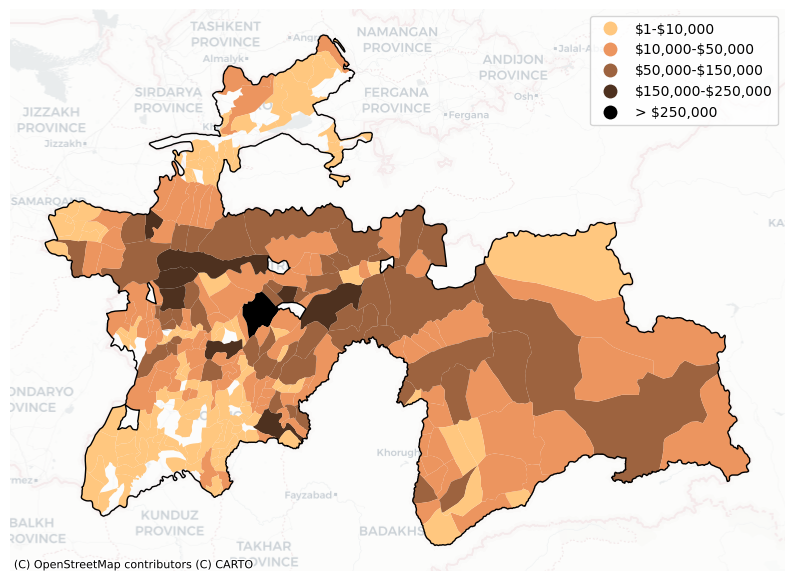

In [44]:
subnational_df['binned'] =  pd.cut(subnational_df.ead,[0,1e4,5e4,1.5e5,2.5e5,subnational_df.ead.max()],labels=['\\$1-$10,000','\\$10,000-$50,000','\\$50,000-$150,000',
                                                                                                       '\\$150,000-$250,000','> $250,000'])
fig, ax = plt.subplots(1,1,figsize=(10, 10))

subnational_df.plot(column = 'binned',cmap='copper_r',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
subnational_df.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')
ax.set_axis_off()

plt.savefig(figures_path /'landslide_rf_historical_EAD_municipal.png', bbox_inches='tight', dpi=300)

In [40]:
subnational_df.ead.max()

264716.84666143986

In [45]:
ead_df['damage/km'] = ead_df.ead/(ead_df.ead_1000_overlay/1000)
ead_df['damage/km'].max()

5976.084865330844

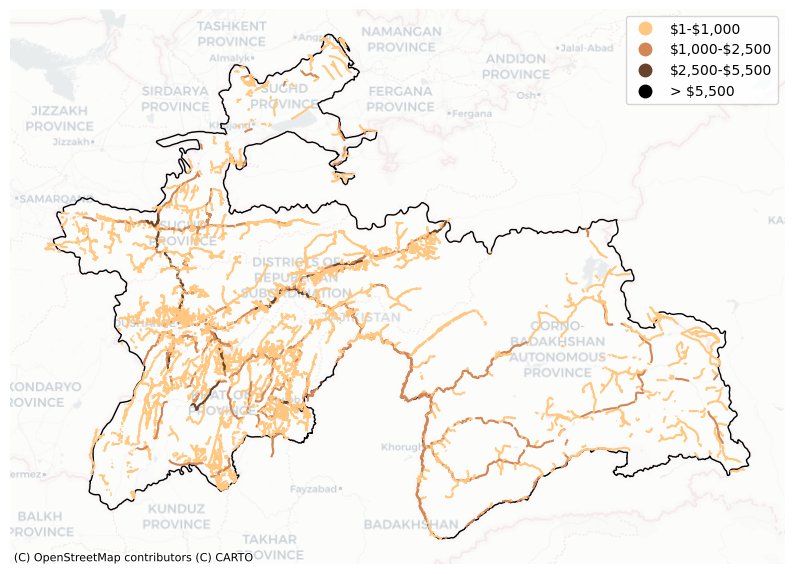

In [48]:
# figure EAD damages per km per road segment
ead_df['damage/km_binned'] = pd.cut(ead_df['damage/km'],[0,1e3,2.5e3,5.5e3,ead_df['damage/km'].max()],labels=['\\$1-$1,000','\\$1,000-$2,500','\\$2,500-$5,500','> $5,500'])
ead_df = gpd.GeoDataFrame(ead_df, geometry='geometry') # Set the GeoDataFrame's geometry column
ead_df = ead_df.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

ead_df.plot(column ='damage/km_binned',cmap='copper_r',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

plt.savefig(figures_path /'landslide_rf_historical_EAD_km.png', bbox_inches='tight', dpi=300)

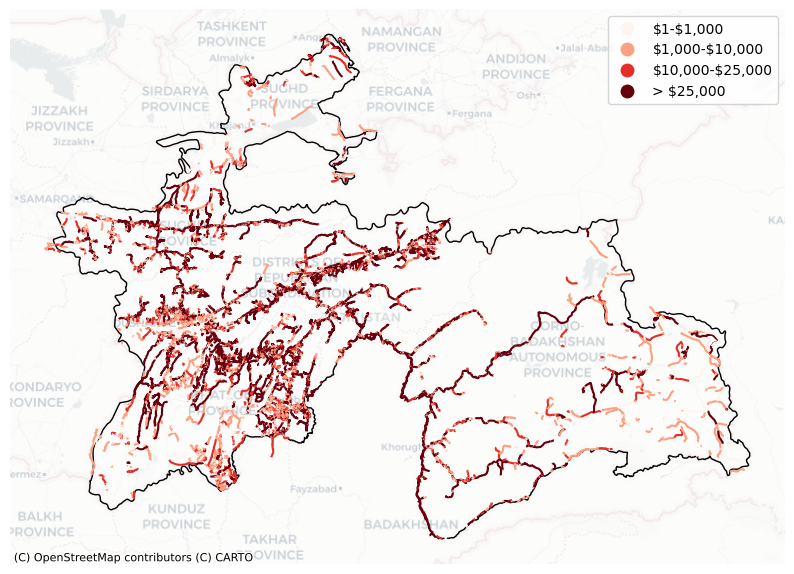

In [84]:
# figure EAD due to rainfall-triggered landslide events due to 1000 year RP rainfall: damages per OSM road segment
ead_df['ead_1000_binned'] = pd.cut(ead_df['ead_1000'],[0,1e3,1e4,2.5e4,ead_df['ead_1000'].max()],labels=['\\$1-$1,000','\\$1,000-$10,000','\\$10,000-$25,000','> $25,000'])
ead_df = gpd.GeoDataFrame(ead_df, geometry='geometry') # Set the GeoDataFrame's geometry column
ead_df = ead_df.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

ead_df.plot(column ='ead_1000_binned',cmap='Reds',legend=True,ax=ax)
#damage_df.plot(column ='Partial destruction (0.5)',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

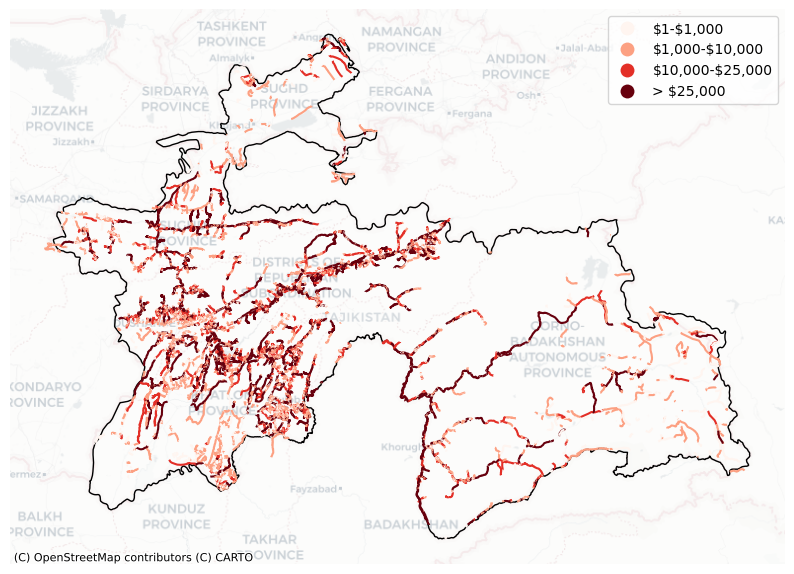

In [85]:
# figure EAD due to rainfall-triggered landslide events due to 25 year RP rainfall: damages per OSM road segment
ead_df['ead_25_binned'] = pd.cut(ead_df['ead_25'],[0,1e3,1e4,2.5e4,ead_df['ead_1000'].max()],labels=['\\$1-$1,000','\\$1,000-$10,000','\\$10,000-$25,000','> $25,000'])
ead_df = gpd.GeoDataFrame(ead_df, geometry='geometry') # Set the GeoDataFrame's geometry column
ead_df = ead_df.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

ead_df.plot(column ='ead_25_binned',cmap='Reds',legend=True,ax=ax)
#damage_df.plot(column ='Partial destruction (0.5)',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

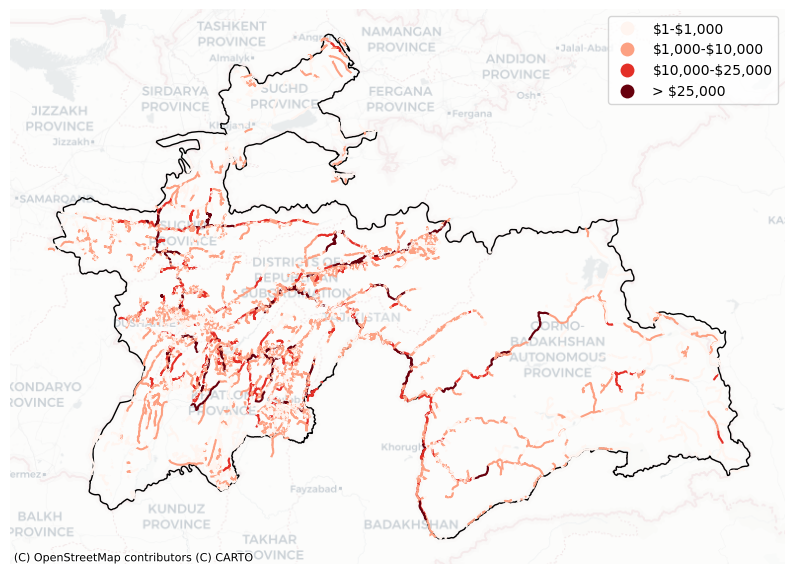

In [86]:
# figure EAD due to rainfall-triggered landslides: damages per OSM road segment
ead_df['ead_binned'] = pd.cut(ead_df['ead'],[0,1e3,1e4,2.5e4,ead_df['ead'].max()],labels=['\\$1-$1,000','\\$1,000-$10,000','\\$10,000-$25,000','> $25,000'])
ead_df = gpd.GeoDataFrame(ead_df, geometry='geometry') # Set the GeoDataFrame's geometry column
ead_df = ead_df.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

ead_df.plot(column ='ead_binned',cmap='Reds',legend=True,ax=ax)
#damage_df.plot(column ='Partial destruction (0.5)',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

plt.savefig(figures_path /'landslide_rf_historical_EAD.png', bbox_inches='tight', dpi=300)

In [87]:
ead_df.ead_binned.value_counts()

ead_binned
\$1-$1,000          11300
\$1,000-$10,000      1971
\$10,000-$25,000      174
> $25,000              93
Name: count, dtype: int64

In [88]:
# project road of interest
dangara_gulliston_ids = dangara_gulliston_ids = ['629623298', '588578885', '667337582', '32623282', '32623136']
project_df = ead_df[ead_df['osm_id'].isin(dangara_gulliston_ids)]

project_df

osm_id      asset  \
33780   32623136    primary   
33781   32623282    primary   
56908  588578885    primary   
58990  629623298  secondary   
61328  667337582    primary   

                                                geometry  ead_5       ead_25  \
33780  LINESTRING (7736373.045 4543194.954, 7736307.6...    0.0  4454.832436   
33781  LINESTRING (7722016.760 4553162.418, 7721756.9...    0.0   333.861131   
56908  LINESTRING (7717996.190 4586923.107, 7718996.8...    0.0     0.000000   
58990  LINESTRING (7718612.287 4592854.748, 7718613.9...    0.0     0.000000   
61328  LINESTRING (7720909.666 4582235.532, 7720692.5...    0.0  1919.293413   

           ead_200     ead_1000  ead_5_overlay  ead_25_overlay  \
33780  7111.630104  7111.630104            0.0      177.119845   
33781   532.971083   532.971083            0.0       13.273997   
56908     0.000000     0.000000            0.0        0.000000   
58990     0.000000     0.000000            0.0        0.000000   
61328  3063.932261  3063.932261            0.0       76.309256   

       ead_200_overlay  ead_1000_overlay  ead_5_number_landslides  \
33780       177.119845        177.119845                      0.0   
33781        13.273997         13.273997                      0.0   
56908         0.000000          0.000000                      0.0   
58990         0.000000          0.000000                      0.0   
61328        76.309256         76.309256                      0.0   

       ead_25_number_landslides  ead_200_number_landslides  \
33780                       4.0                        4.0   
33781                       1.0                        1.0   
56908                       0.0                        0.0   
58990                       0.0                        0.0   
61328                       2.0                        2.0   

       ead_1000_number_landslides         ead        GID_3  ead_1000_binned  \
33780                         4.0  594.357839  TJK.3.3.7_1  \$1,000-$10,000   
33781                         1.0   44.543310  TJK.3.3.7_1       \$1-$1,000   
56908                         0.0    0.000000  TJK.3.3.3_1              NaN   
58990                         0.0    0.000000  TJK.3.3.3_1              NaN   
61328                         2.0  256.069583  TJK.3.3.7_1  \$1,000-$10,000   

         ead_25_binned  ead_binned  
33780  \$1,000-$10,000  \$1-$1,000  
33781       \$1-$1,000  \$1-$1,000  
56908              NaN         NaN  
58990              NaN         NaN  
61328  \$1,000-$10,000  \$1-$1,000

In [89]:
print(shapely.length(project_df['geometry'])/1000) # length of road segments in km
print(sum(shapely.length(project_df['geometry'])/1000)) # total length of road segments in km

33780    22.976544
33781    20.829034
56908     6.368039
58990     6.674631
61328    10.498568
Name: geometry, dtype: float64
67.34681578690605


In [94]:
damage = sum(project_df['ead'])
affected_road = sum(project_df['ead_1000_overlay'])/1000
number_of_landslides = sum(project_df['ead_1000_number_landslides'])
road_segments_length = 22.976544 + 20.829034 + 10.498568

print('The expected annual damage for Dangara-Gulliston road project, based on total length of project road: {:.2f} dollar per km'.format(damage/67.34681578690605))
print('The expected annual damage for Dangara-Gulliston road project, based on length of affected OSM road segment: {:.2f} dollar per km'.format(damage/road_segments_length)) 
print('The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: {:.2f} dollar per km'.format(damage/affected_road)) 
print('The expected annual damage for Dangara-Gulliston road project per landslide event: {:.2f} dollar'.format(damage/number_of_landslides)) #shouldn't we divide by the average landslides per year?

The expected annual damage for Dangara-Gulliston road project, based on total length of project road: 13.29 dollar per km
The expected annual damage for Dangara-Gulliston road project, based on length of affected OSM road segment: 16.48 dollar per km
The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: 3355.68 dollar per km
The expected annual damage for Dangara-Gulliston road project per landslide event: 127.85 dollar


In [91]:
sum(project_df['ead'])

894.9707320077977

In [92]:
sum(project_df['ead_1000_overlay'])/1000 #affected road segments

0.2667030978413808

In [13]:
# exposed roads
print("This is the road length exposed at national level: {:.2f}".format(ead_df.ead_1000_overlay.sum()/1000))
print("This is the EAD at national level: {:.2f}".format(ead_df.ead.sum()))

affected_road = ead_df.ead_1000_overlay.sum()/1000
damage = ead_df.ead.sum()
print('The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: {:.2f} dollar per km'.format(damage/affected_road))

This is the road length exposed at national level: 12716.51
This is the EAD at national level: 14878951.64
The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: 1170.05 dollar per km


## Future conditions SSP126

In [49]:
#read parquets per return period
haz_trig_rp_lst = [5, 25, 200, 1000]
landslide_rp_lst = [5.0, 7.0, 10.0, 20.0, 33.0, 50.0, 100.0]
road_types_lst = ['unclassified', 'primary', 'secondary', 'tertiary', 'residential', 
                                'trunk', 'trunk_link',  'motorway','motorway_link',  'primary_link','secondary_link', 'tertiary_link','road', 'track' ]

#create df with all unique ID numbers, geometry and column ead
ead_df = gpd.GeoDataFrame(columns=['osm_id', 'asset', 'geometry']+['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst] 
                          +['ead_{}_overlay'.format(rp_trig) for rp_trig in haz_trig_rp_lst] +['ead_{}_number_landslides'.format(rp_trig) for rp_trig in haz_trig_rp_lst], geometry='geometry')

for rp_trig in haz_trig_rp_lst:
    damage_data_path_list = fut126_rainfall_damage_data_path.iterdir()
    rp_trig_path_list = [path for path in damage_data_path_list if '_trig{}'.format(rp_trig) in str(path)]

    damages_dict = {key: pd.DataFrame() for key in landslide_rp_lst}
    for data_path in rp_trig_path_list:
        df = gpd.read_parquet(data_path)
        damages_dict[df['return_period_landslide'].unique()[0]] = pd.concat([damages_dict[df['return_period_landslide'].unique()[0]], df], ignore_index=True)  #create dictionary with the return period 

    #modify dictionaries 
    non_empty_rps = [key for key, df in damages_dict.items() if not df.empty]
    if non_empty_rps:
        lowest_non_empty_rp = min(non_empty_rps)
        damages_dict = {key: df for key, df in damages_dict.items() if key >= lowest_non_empty_rp} # Step 1: Remove all keys above this return period
        highest_non_empty_rp = max(non_empty_rps)
        damages_dict = {key: df for key, df in damages_dict.items() if key <= highest_non_empty_rp} # Step 2: Remove all keys below this return period
        for rp in damages_dict.keys():
            #print('This is the total damage for landslide return period {} given rainfall event of {}: {:,.2f}; exposed roads: {:.2f} km'.format(rp, rp_trig, damages_dict[rp]['Partial destruction (0.5)'].sum(), damages_dict[rp]['Overlay'].sum()/1000))
            print('This is the total damage for landslide return period {} given rainfall event of {}: {:,.2f}'.format(rp, rp_trig, damages_dict[rp]['Partial destruction (0.5)'].sum()))   
        
        # Calculate EAD per OSM road segment for rainfall event
        combined_df = pd.concat([damages_dict[rp] for rp in damages_dict.keys()]) #merge dataframes into one
        combined_df['Partial destruction (0.5)'] = combined_df['Partial destruction (0.5)'].fillna(0)
        temp_df = combined_df.drop_duplicates(subset=['osm_id']) # remove duplicates
        ead_df = pd.merge(ead_df, temp_df[['osm_id', 'asset', 'geometry']], on=['osm_id', 'asset', 'geometry'], how='outer')
        
        pivoted_damages = combined_df.pivot_table(index='osm_id', columns='return_period_landslide', values='Partial destruction (0.5)', fill_value=0)
        
        print("Unique osm_id in original data:", combined_df['osm_id'].nunique()) # Print unique osm_id from the original DataFrame
        print("Unique osm_id in pivoted data:", pivoted_damages.index.nunique()) # Print unique osm_id from the pivoted DataFrame
        missing_ids = set(combined_df['osm_id']) - set(pivoted_damages.index) # Check if some osm_id values are missing from pivoted_damages
        print("Missing osm_id values:", missing_ids)
        
        ead_df['ead_{}'.format(rp_trig)] = ead_df.apply(lambda row: calculate_risk_vectorized(pivoted_damages.loc[row['osm_id']]) if row['osm_id'] in pivoted_damages.index else 0, axis=1)

        #fill in overlay columns
        overlay_dict = damages_dict[highest_non_empty_rp].set_index('osm_id')['Overlay'].to_dict()
        ead_df['ead_{}_overlay'.format(rp_trig)] = ead_df['osm_id'].map(overlay_dict)

        #fill in number of landslides columns
        number_landslide_dict = damages_dict[highest_non_empty_rp].set_index('osm_id')['number of landslides'].to_dict()
        ead_df['ead_{}_number_landslides'.format(rp_trig)] = ead_df['osm_id'].map(number_landslide_dict)

ead_df = handle_zero_values(ead_df, haz_trig_rp_lst) # Handle 0 values for higher return periods with damages for the lower return periods

This is the total damage for landslide return period 20.0 given rainfall event of 5: 197,085.30
This is the total damage for landslide return period 33.0 given rainfall event of 5: 1,220,073.46
This is the total damage for landslide return period 50.0 given rainfall event of 5: 10,401,108.79
This is the total damage for landslide return period 100.0 given rainfall event of 5: 69,638,584.87
Unique osm_id in original data: 82856
Unique osm_id in pivoted data: 82856
Missing osm_id values: set()
This is the total damage for landslide return period 10.0 given rainfall event of 25: 65,924,901.17
This is the total damage for landslide return period 20.0 given rainfall event of 25: 255,249,004.95
This is the total damage for landslide return period 33.0 given rainfall event of 25: 1,014,531,374.17
This is the total damage for landslide return period 50.0 given rainfall event of 25: 3,437,629,342.47
Unique osm_id in original data: 83324
Unique osm_id in pivoted data: 83324
Missing osm_id values

In [50]:
# Calculate EAD for earthquake-triggered landslides
ead_df[['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst]] = ead_df[['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst]].fillna(0)
temp_df = (ead_df.filter(['osm_id']+['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst], axis=1)).set_index('osm_id')
ead_df['ead'] = ead_df.apply(lambda row: calculate_risk_vectorized(temp_df.loc[row['osm_id']]), axis=1)
ead_df = ead_df.to_crs(3857)

for rp_trig in haz_trig_rp_lst:
    print('This is the EAD given rainfall event of {}: {:,}'.format(rp_trig, ead_df['ead_{}'.format(rp_trig)].sum()))
print('This is the national EAD for rainfall-triggered landslides: {}'.format(sum(ead_df['ead'])))
print('This is the max EAD for rainfall-triggered landslides for a road segment: {}'.format(max(ead_df['ead'])))

This is the EAD given rainfall event of 5: 1,175,335.0054785106
This is the EAD given rainfall event of 25: 112,222,720.37177724
This is the EAD given rainfall event of 200: 204,022,469.41106936
This is the EAD given rainfall event of 1000: 228,393,232.47084883
This is the national EAD for rainfall-triggered landslides: 10053023.302335504
This is the max EAD for rainfall-triggered landslides for a road segment: 140605.63608825873


In [51]:
ead_df 

osm_id        asset  \
0      1000015176  residential   
1      1000015177  residential   
2      1000015178  residential   
3      1000027175        track   
4      1000027177        track   
...           ...          ...   
83319   999921517  residential   
83320   999921518  residential   
83321    99993370  residential   
83322    99993371  residential   
83323    99995066  residential   

                                                geometry  ead_5       ead_25  \
0      LINESTRING (7782705.330 4564576.153, 7782717.3...    0.0     0.000000   
1      LINESTRING (7782724.555 4564607.850, 7782737.9...    0.0     0.000000   
2      LINESTRING (7782744.292 4564636.373, 7782712.1...    0.0     0.000000   
3      LINESTRING (7778210.260 4603750.917, 7778222.7...    0.0  1405.643742   
4      LINESTRING (7777983.581 4603910.302, 7778013.4...    0.0  1886.553189   
...                                                  ...    ...          ...   
83319  LINESTRING (7775151.045 4619581.078, 7775171.3...    0.0  3219.130824   
83320  LINESTRING (7775173.064 4619806.300, 7775164.4...    0.0   975.182029   
83321  LINESTRING (7653166.156 4655226.289, 7653261.7...    0.0     0.000000   
83322  LINESTRING (7653261.702 4655492.313, 7653285.8...    0.0     0.000000   
83323  LINESTRING (7652266.561 4660580.797, 7652285.2...    0.0     0.000000   

           ead_200     ead_1000  ead_5_overlay  ead_25_overlay  \
0         0.000000     0.000000            0.0        0.000000   
1         0.000000     0.000000            0.0        0.000000   
2         0.000000     0.000000            0.0        0.000000   
3      2278.650243  4128.735255            0.0      359.925847   
4      3523.938980  4698.585308            0.0      313.239021   
...            ...          ...            ...             ...   
83319  5414.167632  5414.167632            0.0      451.744988   
83320  1577.793191  1577.793191            0.0      150.488490   
83321     0.000000     0.000000            0.0        0.000000   
83322     0.000000     0.000000            0.0        0.000000   
83323     0.000000     0.000000            0.0        0.000000   

       ead_200_overlay  ead_1000_overlay  ead_5_number_landslides  \
0             0.000000          0.000000                      0.0   
1             0.000000          0.000000                      0.0   
2             0.000000          0.000000                      0.0   
3           359.925847        359.925847                      0.0   
4           313.239021        313.239021                      0.0   
...                ...               ...                      ...   
83319       451.744988        451.744988                      0.0   
83320       150.488490        150.488490                      0.0   
83321         0.000000          0.000000                      0.0   
83322         0.000000          0.000000                      0.0   
83323         0.000000          0.000000                      0.0   

       ead_25_number_landslides  ead_200_number_landslides  \
0                           0.0                        0.0   
1                           0.0                        0.0   
2                           0.0                        0.0   
3                           5.0                        5.0   
4                           5.0                        5.0   
...                         ...                        ...   
83319                       7.0                        7.0   
83320                       3.0                        3.0   
83321                       0.0                        0.0   
83322                       0.0                        0.0   
83323                       0.0                        0.0   

       ead_1000_number_landslides         ead  
0                             0.0    0.000000  
1                             0.0    0.000000  
2                             0.0    0.000000  
3                             5.0  123.587963  
4                             5.0 

In [52]:
subnational_df = gpd.read_file(admin_path / 'gadm41_TJK.gpkg',layer=3)
subnational_df = subnational_df.to_crs(3857)
ead_df['GID_3'] = ead_df.apply(lambda road_segment: get_province(road_segment, subnational), axis=1)
subnational_df = subnational_df.merge(ead_df[['GID_3','ead']].groupby('GID_3').sum(),left_on='GID_3',right_index=True)
subnational_df[['NAME_2','ead']].groupby('NAME_2').sum().sort_values(by='ead',ascending=False)

ead
NAME_2                             
Ayni                   1.185300e+06
Varzob                 7.183169e+05
Rasht                  5.927345e+05
Jirgatol               5.847808e+05
Khovaling              4.121917e+05
Nurobod                3.995655e+05
Shurobod               3.841159e+05
Rudaki                 3.701268e+05
Darvoz                 3.601514e+05
Rushon                 3.494387e+05
Tavildara              2.769844e+05
Danghara               2.654682e+05
Roghun                 2.647168e+05
Baljuvon               2.586750e+05
Mir Said Ali Hamadoni  2.544993e+05
Vahdat                 2.424976e+05
Norak                  2.377466e+05
Muminobod              2.286328e+05
Kuhistoni Mastchoh     2.089912e+05
Hissor                 1.810776e+05
Vanj                   1.772616e+05
Murghob                1.711977e+05
Pandjakent             1.694526e+05
Roshtqala              1.645760e+05
Shughnon               1.522896e+05
Ishkoshim              1.406313e+05
Asht                   1.114465e+05
Kulob                  9.850682e+04
Ghonchi                9.507242e+04
Fayzobod               8.793225e+04
Temurmalik             8.771297e+04
Shahrinav              8.424784e+04
Yovon                  7.763306e+04
Khuroson               7.174411e+04
Farkhor                7.017109e+04
Jomi                   6.095937e+04
Ghafurov               4.303750e+04
Panj                   4.051467e+04
Tojikobod              3.868867e+04
Matchin                3.437669e+04
Shahriston             3.124997e+04
Vose                   2.887110e+04
Tursunzoda             2.428112e+04
Isfara                 1.608804e+04
Jilikul                1.357748e+04
Sarband                1.152377e+04
Spitamen               8.181396e+03
Istaravshan            6.781474e+03
Shahrituz              5.938973e+03
Kolkhozobod            4.556211e+03
Qabodiyon              4.407076e+03
Jabor Rasulov          3.320654e+03
Vakhsh                 1.823427e+03
Nosir Khusrav          9.110144e+02
Qumsangir              5.924365e+02
Konibodom              0.000000e+00
Bokhtar                0.000000e+00
Zafarobod              0.000000e+00

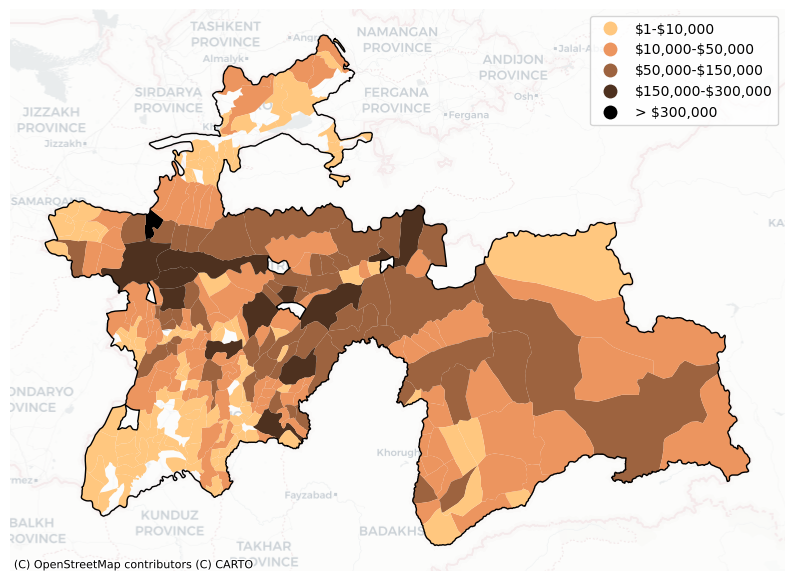

In [59]:
subnational_df['binned'] =  pd.cut(subnational_df.ead,[0,1e4,5e4,1.5e5,3e5,subnational_df.ead.max()],labels=['\\$1-$10,000','\\$10,000-$50,000','\\$50,000-$150,000',
                                                                                                       '\\$150,000-$300,000','> $300,000'])
fig, ax = plt.subplots(1,1,figsize=(10, 10))

subnational_df.plot(column = 'binned',cmap='copper_r',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
subnational_df.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')
ax.set_axis_off()

plt.savefig(figures_path /'landslide_rf_SSP126_EAD_municipal.png', bbox_inches='tight', dpi=300)

In [54]:
subnational_df.ead.max()

314517.5896911713

In [55]:
ead_df['damage/km'] = ead_df.ead/(ead_df.ead_1000_overlay/1000)
ead_df['damage/km'].max()

7482.1428380000025

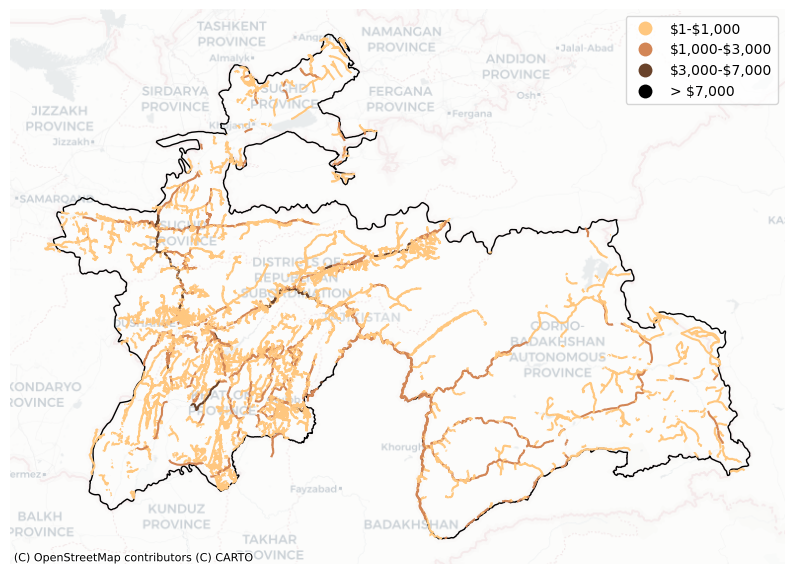

In [58]:
# figure EAD damages per km per road segment
ead_df['damage/km_binned'] = pd.cut(ead_df['damage/km'],[0,1e3,3e3,7e3,ead_df['damage/km'].max()],labels=['\\$1-$1,000','\\$1,000-$3,000','\\$3,000-$7,000','> $7,000'])
ead_df = gpd.GeoDataFrame(ead_df, geometry='geometry') # Set the GeoDataFrame's geometry column
ead_df = ead_df.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

ead_df.plot(column ='damage/km_binned',cmap='copper_r',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

plt.savefig(figures_path /'landslide_rf_SSP126_EAD_km.png', bbox_inches='tight', dpi=300)

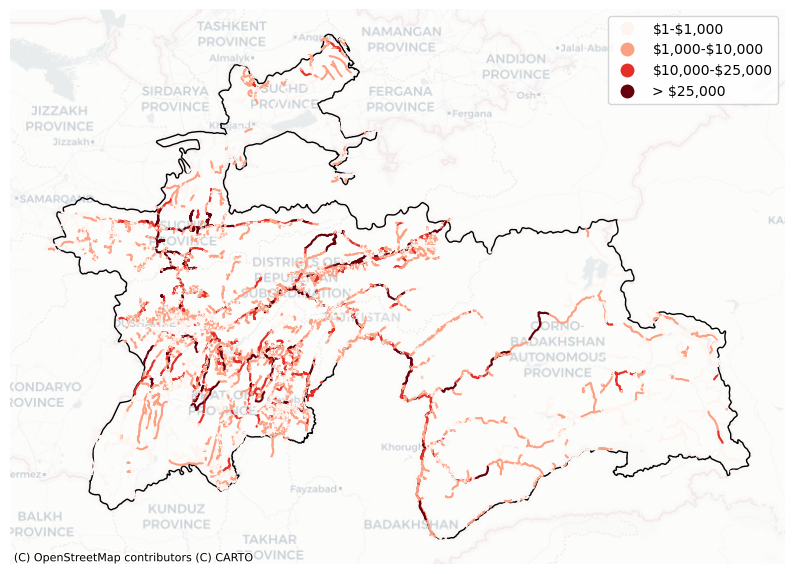

In [11]:
# figure EAD due to rainfall-triggered landslides: damages per OSM road segment
ead_df['ead_binned'] = pd.cut(ead_df['ead'],[0,1e3,1e4,2.5e4,ead_df['ead'].max()],labels=['\\$1-$1,000','\\$1,000-$10,000','\\$10,000-$25,000','> $25,000'])
ead_df = gpd.GeoDataFrame(ead_df, geometry='geometry') # Set the GeoDataFrame's geometry column
ead_df = ead_df.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

ead_df.plot(column ='ead_binned',cmap='Reds',legend=True,ax=ax)
#damage_df.plot(column ='Partial destruction (0.5)',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

plt.savefig(figures_path /'landslide_rf_ssp126_EAD.png', bbox_inches='tight', dpi=300)

In [37]:
ead_df.ead.max()

775406.7649984619

In [12]:
ead_df.ead_binned.value_counts()

ead_binned
\$1-$1,000          11858
\$1,000-$10,000      2182
\$10,000-$25,000      208
> $25,000             125
Name: count, dtype: int64

In [13]:
# project road of interest
dangara_gulliston_ids = dangara_gulliston_ids = ['629623298', '588578885', '667337582', '32623282', '32623136']
project_df = ead_df[ead_df['osm_id'].isin(dangara_gulliston_ids)]

project_df

osm_id      asset  \
33780   32623136    primary   
33781   32623282    primary   
56908  588578885    primary   
58990  629623298  secondary   
61328  667337582    primary   

                                                geometry  ead_5        ead_25  \
33780  LINESTRING (7736373.045 4543194.954, 7736307.6...    0.0  85487.395536   
33781  LINESTRING (7722016.760 4553162.418, 7721756.9...    0.0  27318.485283   
56908  LINESTRING (7717996.190 4586923.107, 7718996.8...    0.0      0.000000   
58990  LINESTRING (7718612.287 4592854.748, 7718613.9...    0.0      0.000000   
61328  LINESTRING (7720909.666 4582235.532, 7720692.5...    0.0   1919.293413   

             ead_200       ead_1000  ead_5_overlay  ead_25_overlay  \
33780  136470.842474  136470.842474            0.0     3398.896463   
33781   43610.835005   43610.835005            0.0     1086.156648   
56908       0.000000       0.000000            0.0        0.000000   
58990       0.000000       0.000000            0.0        0.000000   
61328    3063.932261    3063.932261            0.0       76.309256   

       ead_200_overlay  ead_1000_overlay  ead_5_number_landslides  \
33780      3398.896463       3398.896463                      0.0   
33781      1086.156648       1086.156648                      0.0   
56908         0.000000          0.000000                      0.0   
58990         0.000000          0.000000                      0.0   
61328        76.309256         76.309256                      0.0   

       ead_25_number_landslides  ead_200_number_landslides  \
33780                      52.0                       52.0   
33781                      14.0                       14.0   
56908                       0.0                        0.0   
58990                       0.0                        0.0   
61328                       2.0                        2.0   

       ead_1000_number_landslides           ead        GID_3        ead_binned  
33780                        52.0  11405.615007  TJK.3.3.7_1  \$10,000-$25,000  
33781                        14.0   3644.796098  TJK.3.3.7_1   \$1,000-$10,000  
56908                         0.0      0.000000  TJK.3.3.3_1               NaN  
58990                         0.0      0.000000  TJK.3.3.3_1               NaN  
61328                         2.0    256.069583  TJK.3.3.7_1        \$1-$1,000

In [14]:
print(shapely.length(project_df['geometry'])/1000) # length of road segments in km
print(sum(shapely.length(project_df['geometry'])/1000)) # total length of road segments in km

33780    22.976544
33781    20.829034
56908     6.368039
58990     6.674631
61328    10.498568
Name: geometry, dtype: float64
67.34681578690605


In [16]:
damage = sum(project_df['ead'])
affected_road = sum(project_df['ead_1000_overlay'])/1000
number_of_landslides = sum(project_df['ead_1000_number_landslides'])
road_segments_length = 22.976544 + 20.829034 + 10.498568

print('The expected annual damage for Dangara-Gulliston road project, based on total length of project road: {:.2f} dollar per km'.format(damage/67.34681578690605))
print('The expected annual damage for Dangara-Gulliston road project, based on length of affected OSM road segment: {:.2f} dollar per km'.format(damage/road_segments_length)) 
print('The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: {:.2f} dollar per km'.format(damage/affected_road)) 
print('The expected annual damage for Dangara-Gulliston road project per landslide event: {:.2f} dollar'.format(damage/number_of_landslides)) #shouldn't we divide by the average landslides per year?

The expected annual damage for Dangara-Gulliston road project, based on total length of project road: 227.28 dollar per km
The expected annual damage for Dangara-Gulliston road project, based on length of affected OSM road segment: 281.87 dollar per km
The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: 3355.68 dollar per km
The expected annual damage for Dangara-Gulliston road project per landslide event: 225.10 dollar


In [54]:
sum(project_df['ead'])

15306.480688444446

In [17]:
sum(project_df['ead_1000_overlay'])/1000

4.561362367123573

In [17]:
# exposed roads
print("This is the road length exposed at national level: {:.2f}".format(ead_df.ead_1000_overlay.sum()/1000))
print("This is the EAD at national level: {:.2f}".format(ead_df.ead.sum()))

affected_road = ead_df.ead_1000_overlay.sum()/1000
damage = ead_df.ead.sum()
print('The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: {:.2f} dollar per km'.format(damage/affected_road))

This is the road length exposed at national level: 13685.47
This is the EAD at national level: 19984559.18
The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: 1460.28 dollar per km


## Future conditions SSP585

In [60]:
#read parquets per return period
haz_trig_rp_lst = [5, 25, 200, 1000]
landslide_rp_lst = [5.0, 7.0, 10.0, 20.0, 33.0, 50.0, 100.0]
road_types_lst = ['primary']

#create df with all unique ID numbers, geometry and column ead
ead_df = gpd.GeoDataFrame(columns=['osm_id', 'asset', 'geometry']+['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst] 
                          +['ead_{}_overlay'.format(rp_trig) for rp_trig in haz_trig_rp_lst] +['ead_{}_number_landslides'.format(rp_trig) for rp_trig in haz_trig_rp_lst], geometry='geometry')

for rp_trig in haz_trig_rp_lst:
    damage_data_path_list = fut585_rainfall_damage_data_path.iterdir()
    rp_trig_path_list = [path for path in damage_data_path_list if '_trig{}'.format(rp_trig) in str(path)]

    damages_dict = {key: pd.DataFrame() for key in landslide_rp_lst}
    for data_path in rp_trig_path_list:
        df = gpd.read_parquet(data_path)
        damages_dict[df['return_period_landslide'].unique()[0]] = pd.concat([damages_dict[df['return_period_landslide'].unique()[0]], df], ignore_index=True)  #create dictionary with the return period 

    #modify dictionaries 
    non_empty_rps = [key for key, df in damages_dict.items() if not df.empty]
    if non_empty_rps:
        lowest_non_empty_rp = min(non_empty_rps)
        damages_dict = {key: df for key, df in damages_dict.items() if key >= lowest_non_empty_rp} # Step 1: Remove all keys above this return period
        highest_non_empty_rp = max(non_empty_rps)
        damages_dict = {key: df for key, df in damages_dict.items() if key <= highest_non_empty_rp} # Step 2: Remove all keys below this return period
        for rp in damages_dict.keys():
            #print('This is the total damage for landslide return period {} given rainfall event of {}: {:,.2f}; exposed roads: {:.2f} km'.format(rp, rp_trig, damages_dict[rp]['Partial destruction (0.5)'].sum(), damages_dict[rp]['Overlay'].sum()/1000))
            print('This is the total damage for landslide return period {} given rainfall event of {}: {:,.2f}'.format(rp, rp_trig, damages_dict[rp]['Partial destruction (0.5)'].sum()))   
        
        # Calculate EAD per OSM road segment for rainfall event
        combined_df = pd.concat([damages_dict[rp] for rp in damages_dict.keys()]) #merge dataframes into one
        combined_df['Partial destruction (0.5)'] = combined_df['Partial destruction (0.5)'].fillna(0)
        temp_df = combined_df.drop_duplicates(subset=['osm_id']) # remove duplicates
        ead_df = pd.merge(ead_df, temp_df[['osm_id', 'asset', 'geometry']], on=['osm_id', 'asset', 'geometry'], how='outer')
        
        pivoted_damages = combined_df.pivot_table(index='osm_id', columns='return_period_landslide', values='Partial destruction (0.5)', fill_value=0)
        
        print("Unique osm_id in original data:", combined_df['osm_id'].nunique()) # Print unique osm_id from the original DataFrame
        print("Unique osm_id in pivoted data:", pivoted_damages.index.nunique()) # Print unique osm_id from the pivoted DataFrame
        missing_ids = set(combined_df['osm_id']) - set(pivoted_damages.index) # Check if some osm_id values are missing from pivoted_damages
        print("Missing osm_id values:", missing_ids)
        
        ead_df['ead_{}'.format(rp_trig)] = ead_df.apply(lambda row: calculate_risk_vectorized(pivoted_damages.loc[row['osm_id']]) if row['osm_id'] in pivoted_damages.index else 0, axis=1)

        #fill in overlay columns
        overlay_dict = damages_dict[highest_non_empty_rp].set_index('osm_id')['Overlay'].to_dict()
        ead_df['ead_{}_overlay'.format(rp_trig)] = ead_df['osm_id'].map(overlay_dict)

        #fill in number of landslides columns
        number_landslide_dict = damages_dict[highest_non_empty_rp].set_index('osm_id')['number of landslides'].to_dict()
        ead_df['ead_{}_number_landslides'.format(rp_trig)] = ead_df['osm_id'].map(number_landslide_dict)

ead_df = handle_zero_values(ead_df, haz_trig_rp_lst) # Handle 0 values for higher return periods with damages for the lower return periods

This is the total damage for landslide return period 20.0 given rainfall event of 5: 197,085.30
This is the total damage for landslide return period 33.0 given rainfall event of 5: 1,220,073.46
This is the total damage for landslide return period 50.0 given rainfall event of 5: 10,401,108.79
This is the total damage for landslide return period 100.0 given rainfall event of 5: 69,638,584.87
Unique osm_id in original data: 82856
Unique osm_id in pivoted data: 82856
Missing osm_id values: set()
This is the total damage for landslide return period 10.0 given rainfall event of 25: 91,972,074.07
This is the total damage for landslide return period 20.0 given rainfall event of 25: 329,909,489.47
This is the total damage for landslide return period 33.0 given rainfall event of 25: 1,135,395,074.80
This is the total damage for landslide return period 50.0 given rainfall event of 25: 3,540,348,184.72
Unique osm_id in original data: 83324
Unique osm_id in pivoted data: 83324
Missing osm_id values

In [61]:
# Calculate EAD for earthquake-triggered landslides
ead_df[['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst]] = ead_df[['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst]].fillna(0)
temp_df = (ead_df.filter(['osm_id']+['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst], axis=1)).set_index('osm_id')
ead_df['ead'] = ead_df.apply(lambda row: calculate_risk_vectorized(temp_df.loc[row['osm_id']]), axis=1)
ead_df = ead_df.to_crs(3857)

for rp_trig in haz_trig_rp_lst:
    print('This is the EAD given rainfall event of {}: {:,}'.format(rp_trig, ead_df['ead_{}'.format(rp_trig)].sum()))
print('This is the national EAD for rainfall-triggered landslides: {}'.format(sum(ead_df['ead'])))
print('This is the max EAD for rainfall-triggered landslides for a road segment: {}'.format(max(ead_df['ead'])))

This is the EAD given rainfall event of 5: 1,175,335.0054785106
This is the EAD given rainfall event of 25: 119,872,194.47450906
This is the EAD given rainfall event of 200: 217,133,550.3301199
This is the EAD given rainfall event of 1000: 242,513,665.82417685
This is the national EAD for rainfall-triggered landslides: 10714419.310955575
This is the max EAD for rainfall-triggered landslides for a road segment: 140605.63608825873


In [62]:
ead_df 

osm_id        asset  \
0      1000015176  residential   
1      1000015177  residential   
2      1000015178  residential   
3      1000027175        track   
4      1000027177        track   
...           ...          ...   
83319   999921517  residential   
83320   999921518  residential   
83321    99993370  residential   
83322    99993371  residential   
83323    99995066  residential   

                                                geometry  ead_5       ead_25  \
0      LINESTRING (7782705.330 4564576.153, 7782717.3...    0.0     0.000000   
1      LINESTRING (7782724.555 4564607.850, 7782737.9...    0.0     0.000000   
2      LINESTRING (7782744.292 4564636.373, 7782712.1...    0.0     0.000000   
3      LINESTRING (7778210.260 4603750.917, 7778222.7...    0.0  1405.643742   
4      LINESTRING (7777983.581 4603910.302, 7778013.4...    0.0  1886.553189   
...                                                  ...    ...          ...   
83319  LINESTRING (7775151.045 4619581.078, 7775171.3...    0.0  3219.130824   
83320  LINESTRING (7775173.064 4619806.300, 7775164.4...    0.0   975.182029   
83321  LINESTRING (7653166.156 4655226.289, 7653261.7...    0.0     0.000000   
83322  LINESTRING (7653261.702 4655492.313, 7653285.8...    0.0     0.000000   
83323  LINESTRING (7652266.561 4660580.797, 7652285.2...    0.0     0.000000   

           ead_200     ead_1000  ead_5_overlay  ead_25_overlay  \
0         0.000000     0.000000            0.0        0.000000   
1         0.000000     0.000000            0.0        0.000000   
2         0.000000     0.000000            0.0        0.000000   
3      2278.650243  4128.735255            0.0      359.925847   
4      3523.938980  4698.585308            0.0      313.239021   
...            ...          ...            ...             ...   
83319  5414.167632  5414.167632            0.0      451.744988   
83320  1577.793191  1577.793191            0.0      150.488490   
83321     0.000000     0.000000            0.0        0.000000   
83322     0.000000     0.000000            0.0        0.000000   
83323     0.000000     0.000000            0.0        0.000000   

       ead_200_overlay  ead_1000_overlay  ead_5_number_landslides  \
0             0.000000          0.000000                      0.0   
1             0.000000          0.000000                      0.0   
2             0.000000          0.000000                      0.0   
3           359.925847        359.925847                      0.0   
4           313.239021        313.239021                      0.0   
...                ...               ...                      ...   
83319       451.744988        451.744988                      0.0   
83320       150.488490        150.488490                      0.0   
83321         0.000000          0.000000                      0.0   
83322         0.000000          0.000000                      0.0   
83323         0.000000          0.000000                      0.0   

       ead_25_number_landslides  ead_200_number_landslides  \
0                           0.0                        0.0   
1                           0.0                        0.0   
2                           0.0                        0.0   
3                           5.0                        5.0   
4                           5.0                        5.0   
...                         ...                        ...   
83319                       7.0                        7.0   
83320                       3.0                        3.0   
83321                       0.0                        0.0   
83322                       0.0                        0.0   
83323                       0.0                        0.0   

       ead_1000_number_landslides         ead  
0                             0.0    0.000000  
1                             0.0    0.000000  
2                             0.0    0.000000  
3                             5.0  123.587963  
4                             5.0 

In [63]:
subnational_df = gpd.read_file(admin_path / 'gadm41_TJK.gpkg',layer=3)
subnational_df = subnational_df.to_crs(3857)
ead_df['GID_3'] = ead_df.apply(lambda road_segment: get_province(road_segment, subnational), axis=1)
subnational_df = subnational_df.merge(ead_df[['GID_3','ead']].groupby('GID_3').sum(),left_on='GID_3',right_index=True)
subnational_df[['NAME_2','ead']].groupby('NAME_2').sum().sort_values(by='ead',ascending=False)

ead
NAME_2                             
Ayni                   1.433340e+06
Varzob                 7.183169e+05
Jirgatol               7.127765e+05
Rasht                  5.927345e+05
Khovaling              4.121917e+05
Nurobod                3.995655e+05
Shurobod               3.841652e+05
Rudaki                 3.701268e+05
Darvoz                 3.601514e+05
Kuhistoni Mastchoh     3.560548e+05
Rushon                 3.494387e+05
Tavildara              2.769844e+05
Danghara               2.654682e+05
Pandjakent             2.650863e+05
Roghun                 2.647168e+05
Baljuvon               2.586750e+05
Mir Said Ali Hamadoni  2.544993e+05
Vahdat                 2.464179e+05
Norak                  2.377466e+05
Muminobod              2.286328e+05
Murghob                1.907788e+05
Hissor                 1.810776e+05
Vanj                   1.772616e+05
Roshtqala              1.645760e+05
Shughnon               1.522896e+05
Ishkoshim              1.406313e+05
Ghonchi                1.141851e+05
Asht                   1.114465e+05
Kulob                  9.850682e+04
Fayzobod               8.793225e+04
Temurmalik             8.771297e+04
Shahrinav              8.424784e+04
Yovon                  7.763306e+04
Khuroson               7.174411e+04
Farkhor                7.017109e+04
Jomi                   6.095937e+04
Ghafurov               4.303750e+04
Panj                   4.051467e+04
Tojikobod              3.868867e+04
Matchin                3.437669e+04
Shahriston             3.124997e+04
Vose                   2.887110e+04
Tursunzoda             2.428112e+04
Isfara                 1.608804e+04
Jilikul                1.357748e+04
Sarband                1.152377e+04
Spitamen               8.181396e+03
Istaravshan            6.781474e+03
Shahrituz              5.938973e+03
Kolkhozobod            4.556211e+03
Qabodiyon              4.407076e+03
Jabor Rasulov          3.320654e+03
Vakhsh                 1.823427e+03
Nosir Khusrav          9.110144e+02
Qumsangir              5.924365e+02
Konibodom              0.000000e+00
Bokhtar                0.000000e+00
Zafarobod              0.000000e+00

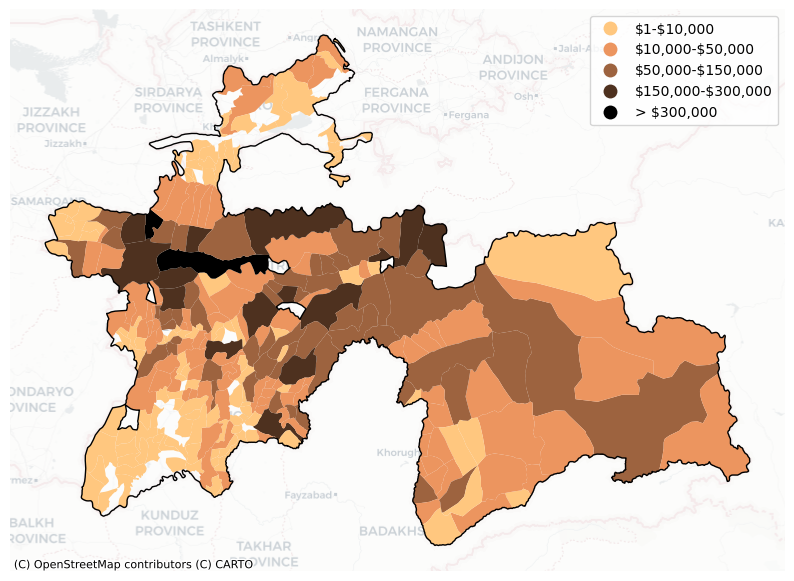

In [64]:
subnational_df['binned'] =  pd.cut(subnational_df.ead,[0,1e4,5e4,1.5e5,3e5,subnational_df.ead.max()],labels=['\\$1-$10,000','\\$10,000-$50,000','\\$50,000-$150,000',
                                                                                                       '\\$150,000-$300,000','> $300,000'])
fig, ax = plt.subplots(1,1,figsize=(10, 10))

subnational_df.plot(column = 'binned',cmap='copper_r',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
subnational_df.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')
ax.set_axis_off()

plt.savefig(figures_path /'landslide_rf_SSP585_EAD_municipal.png', bbox_inches='tight', dpi=300)

In [65]:
subnational_df.ead.max()

331909.52157576004

In [66]:
ead_df['damage/km'] = ead_df.ead/(ead_df.ead_1000_overlay/1000)
ead_df['damage/km'].max()

7482.142838000002

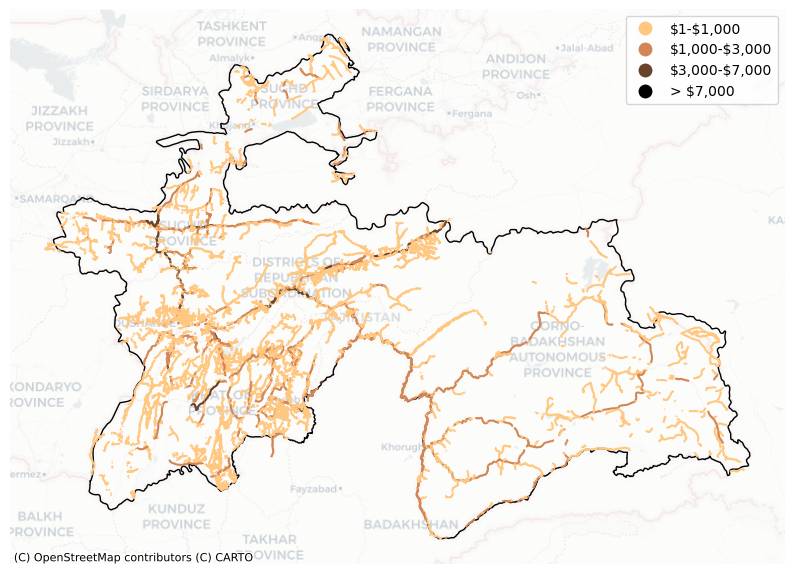

In [67]:
# figure EAD damages per km per road segment
ead_df['damage/km_binned'] = pd.cut(ead_df['damage/km'],[0,1e3,3e3,7e3,ead_df['damage/km'].max()],labels=['\\$1-$1,000','\\$1,000-$3,000','\\$3,000-$7,000','> $7,000'])
ead_df = gpd.GeoDataFrame(ead_df, geometry='geometry') # Set the GeoDataFrame's geometry column
ead_df = ead_df.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

ead_df.plot(column ='damage/km_binned',cmap='copper_r',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

plt.savefig(figures_path /'landslide_rf_SSP585_EAD_km.png', bbox_inches='tight', dpi=300)

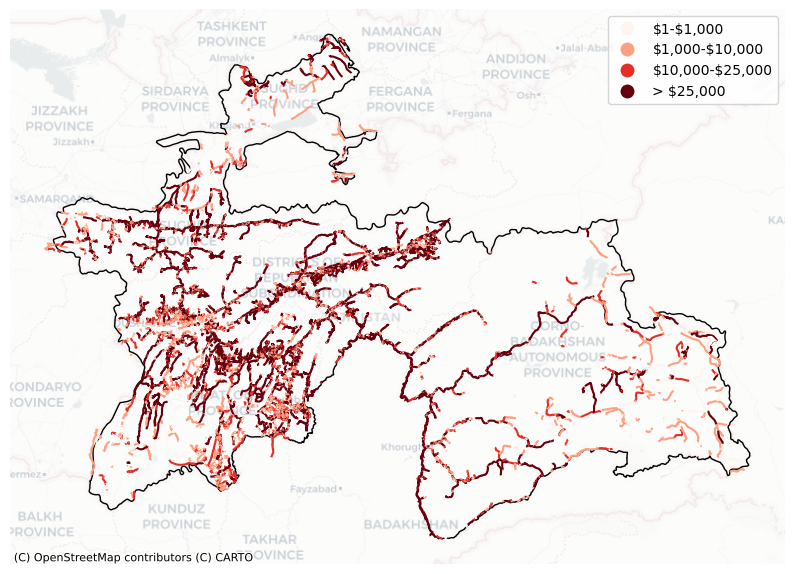

In [23]:
# figure EAD due to rainfall-triggered landslide events due to 1000 year RP rainfall: damages per OSM road segment
ead_df['ead_1000_binned'] = pd.cut(ead_df['ead_1000'],[0,1e3,1e4,2.5e4,ead_df['ead_1000'].max()],labels=['\\$1-$1,000','\\$1,000-$10,000','\\$10,000-$25,000','> $25,000'])
ead_df = gpd.GeoDataFrame(ead_df, geometry='geometry') # Set the GeoDataFrame's geometry column

fig, ax = plt.subplots(1,1,figsize=(10, 10))
subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

ead_df.plot(column ='ead_1000_binned',cmap='Reds',legend=True,ax=ax)
#damage_df.plot(column ='Partial destruction (0.5)',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

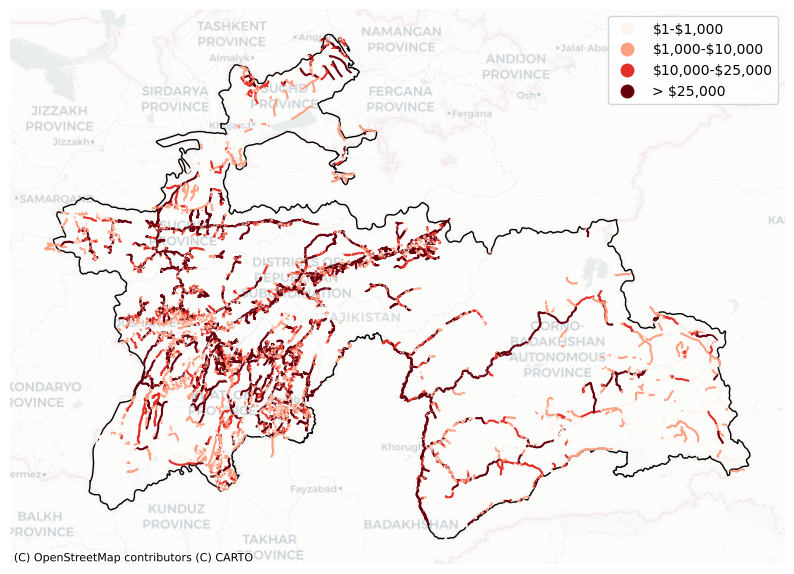

In [24]:
# figure EAD due to rainfall-triggered landslide events due to 25 year RP rainfall: damages per OSM road segment
ead_df['ead_25_binned'] = pd.cut(ead_df['ead_25'],[0,1e3,1e4,2.5e4,ead_df['ead_1000'].max()],labels=['\\$1-$1,000','\\$1,000-$10,000','\\$10,000-$25,000','> $25,000'])
ead_df = gpd.GeoDataFrame(ead_df, geometry='geometry') # Set the GeoDataFrame's geometry column

fig, ax = plt.subplots(1,1,figsize=(10, 10))
subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

ead_df.plot(column ='ead_25_binned',cmap='Reds',legend=True,ax=ax)
#damage_df.plot(column ='Partial destruction (0.5)',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

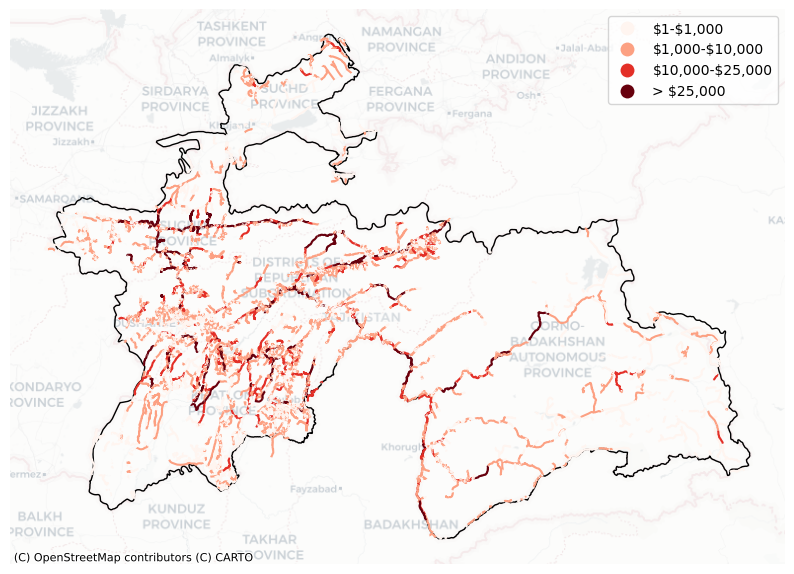

In [25]:
# figure EAD due to rainfall-triggered landslides: damages per OSM road segment
ead_df['ead_binned'] = pd.cut(ead_df['ead'],[0,1e3,1e4,2.5e4,ead_df['ead'].max()],labels=['\\$1-$1,000','\\$1,000-$10,000','\\$10,000-$25,000','> $25,000'])
ead_df = gpd.GeoDataFrame(ead_df, geometry='geometry') # Set the GeoDataFrame's geometry column
ead_df = ead_df.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

ead_df.plot(column ='ead_binned',cmap='Reds',legend=True,ax=ax)
#damage_df.plot(column ='Partial destruction (0.5)',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

plt.savefig(figures_path /'landslide_rf_ssp585_EAD.png', bbox_inches='tight', dpi=300)

In [26]:
# project road of interest
dangara_gulliston_ids = dangara_gulliston_ids = ['629623298', '588578885', '667337582', '32623282', '32623136']
project_df = ead_df[ead_df['osm_id'].isin(dangara_gulliston_ids)]

project_df

osm_id      asset  \
33780   32623136    primary   
33781   32623282    primary   
56908  588578885    primary   
58990  629623298  secondary   
61328  667337582    primary   

                                                geometry  ead_5        ead_25  \
33780  LINESTRING (7736373.045 4543194.954, 7736307.6...    0.0  85487.395536   
33781  LINESTRING (7722016.760 4553162.418, 7721756.9...    0.0  27318.485283   
56908  LINESTRING (7717996.190 4586923.107, 7718996.8...    0.0      0.000000   
58990  LINESTRING (7718612.287 4592854.748, 7718613.9...    0.0      0.000000   
61328  LINESTRING (7720909.666 4582235.532, 7720692.5...    0.0   1919.293413   

             ead_200       ead_1000  ead_5_overlay  ead_25_overlay  \
33780  136470.842474  136470.842474            0.0     3398.896463   
33781   43610.835005   43610.835005            0.0     1086.156648   
56908       0.000000       0.000000            0.0        0.000000   
58990       0.000000       0.000000            0.0        0.000000   
61328    3063.932261    3063.932261            0.0       76.309256   

       ead_200_overlay  ead_1000_overlay  ead_5_number_landslides  \
33780      3398.896463       3398.896463                      0.0   
33781      1086.156648       1086.156648                      0.0   
56908         0.000000          0.000000                      0.0   
58990         0.000000          0.000000                      0.0   
61328        76.309256         76.309256                      0.0   

       ead_25_number_landslides  ead_200_number_landslides  \
33780                      52.0                       52.0   
33781                      14.0                       14.0   
56908                       0.0                        0.0   
58990                       0.0                        0.0   
61328                       2.0                        2.0   

       ead_1000_number_landslides           ead        GID_3  ead_1000_binned  \
33780                        52.0  11405.615007  TJK.3.3.7_1        > $25,000   
33781                        14.0   3644.796098  TJK.3.3.7_1        > $25,000   
56908                         0.0      0.000000  TJK.3.3.3_1              NaN   
58990                         0.0      0.000000  TJK.3.3.3_1              NaN   
61328                         2.0    256.069583  TJK.3.3.7_1  \$1,000-$10,000   

         ead_25_binned        ead_binned  
33780        > $25,000  \$10,000-$25,000  
33781        > $25,000   \$1,000-$10,000  
56908              NaN               NaN  
58990              NaN               NaN  
61328  \$1,000-$10,000        \$1-$1,000

In [27]:
print(shapely.length(project_df['geometry'])/1000) # length of road segments in km
print(sum(shapely.length(project_df['geometry'])/1000)) # total length of road segments in km

33780    22.976544
33781    20.829034
56908     6.368039
58990     6.674631
61328    10.498568
Name: geometry, dtype: float64
67.34681578690605


In [28]:
damage = sum(project_df['ead'])
affected_road = sum(project_df['ead_1000_overlay'])/1000
number_of_landslides = sum(project_df['ead_1000_number_landslides'])
road_segments_length = 22.976544 + 20.829034 + 10.498568

print('The expected annual damage for Dangara-Gulliston road project, based on total length of project road: {:.2f} dollar per km'.format(damage/67.34681578690605))
print('The expected annual damage for Dangara-Gulliston road project, based on length of affected OSM road segment: {:.2f} dollar per km'.format(damage/road_segments_length)) 
print('The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: {:.2f} dollar per km'.format(damage/affected_road)) 
print('The expected annual damage for Dangara-Gulliston road project per landslide event: {:.2f} dollar'.format(damage/number_of_landslides)) #shouldn't we divide by the average landslides per year?

The expected annual damage for Dangara-Gulliston road project, based on total length of project road: 227.28 dollar per km
The expected annual damage for Dangara-Gulliston road project, based on length of affected OSM road segment: 281.87 dollar per km
The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: 3355.68 dollar per km
The expected annual damage for Dangara-Gulliston road project per landslide event: 225.10 dollar


In [29]:
sum(project_df['ead'])

15306.480688444446

In [30]:
sum(project_df['ead_1000_overlay'])/1000

4.5613623671235715

In [21]:
# exposed roads
print("This is the road length exposed at national level: {:.2f}".format(ead_df.ead_1000_overlay.sum()/1000))
print("This is the EAD at national level: {:.2f}".format(ead_df.ead.sum()))

affected_road = ead_df.ead_1000_overlay.sum()/1000
damage = ead_df.ead.sum()
print('The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: {:.2f} dollar per km'.format(damage/affected_road))

This is the road length exposed at national level: 14198.85
This is the EAD at national level: 22529580.47
The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: 1586.72 dollar per km
